In [32]:
import numpy as np
import matplotlib.pyplot as plt

class Sphere:
    def __init__(self, center, radius, color, specular=0, reflective=0):
        self.center = np.array(center)
        self.radius = radius
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective

    def intersects(self, ray_origin, ray_direction):
        oc = ray_origin - self.center
        a = np.dot(ray_direction, ray_direction)
        b = 2 * np.dot(oc, ray_direction)
        c = np.dot(oc, oc) - self.radius ** 2
        discriminant = b ** 2 - 4 * a * c

        if discriminant < 0:
            return None, None

        t1 = (-b - np.sqrt(discriminant)) / (2 * a)
        t2 = (-b + np.sqrt(discriminant)) / (2 * a)
        return t1, t2

class Plane:
    def __init__(self, point, normal, color, specular=0, reflective=0):
        self.point = np.array(point)
        self.normal = np.array(normal) / np.linalg.norm(normal)
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective

    def intersects(self, ray_origin, ray_direction):
        denom = np.dot(ray_direction, self.normal)
        if abs(denom) < 1e-6:
            return None  # No intersection, the ray is parallel to the plane
        t = np.dot(self.point - ray_origin, self.normal) / denom
        return t if t > 0 else None

def closest_intersection(ray_origin, ray_direction, t_min, t_max, objects):
    closest_t = float('inf')
    closest_obj = None

    for obj in objects:
        if isinstance(obj, Sphere):
            t1, t2 = obj.intersects(ray_origin, ray_direction)
            if t1 is not None and t_min < t1 < t_max and t1 < closest_t:
                closest_t = t1
                closest_obj = obj
            if t2 is not None and t_min < t2 < t_max and t2 < closest_t:
                closest_t = t2
                closest_obj = obj
        elif isinstance(obj, Plane):
            t = obj.intersects(ray_origin, ray_direction)
            if t is not None and t_min < t < t_max and t < closest_t:
                closest_t = t
                closest_obj = obj

    return closest_obj, closest_t

def compute_lighting(point, normal, view, specular, lights, objects):
    intensity = 0.0

    for light in lights:
        if light['type'] == 'ambient':
            intensity += light['intensity']
        else:
            light_dir = light['direction'] if light['type'] == 'directional' else light['position'] - point
            light_dir = light_dir / np.linalg.norm(light_dir)
            
            shadow_obj, shadow_t = closest_intersection(point, light_dir, 0.001, float('inf'), objects)
            if shadow_obj is not None:
                continue
            
            n_dot_l = np.dot(normal, light_dir)
            if n_dot_l > 0:
                intensity += light['intensity'] * n_dot_l

            if specular != -1:
                reflection = 2 * normal * np.dot(normal, light_dir) - light_dir
                r_dot_v = np.dot(reflection, view)
                if r_dot_v > 0:
                    intensity += light['intensity'] * (r_dot_v ** specular)

    return intensity

def trace_ray(ray_origin, ray_direction, t_min, t_max, objects, lights, recursion_depth):
    closest_obj, closest_t = closest_intersection(ray_origin, ray_direction, t_min, t_max, objects)
    if closest_obj is None:
        return np.array([220, 230, 250])

    point = ray_origin + closest_t * ray_direction
    normal = (point - closest_obj.center) / closest_obj.radius if isinstance(closest_obj, Sphere) else closest_obj.normal
    view = -ray_direction

    lighting = compute_lighting(point, normal, view, closest_obj.specular, lights, objects)
    local_color = closest_obj.color * lighting

    reflectiveness = closest_obj.reflective
    if recursion_depth <= 0 or reflectiveness <= 0:
        return np.clip(local_color, 0, 255)

    reflection_direction = ray_direction - 2 * np.dot(ray_direction, normal) * normal
    reflection_color = trace_ray(point, reflection_direction, 0.001, float('inf'), objects, lights, recursion_depth - 1)

    final_color = (1 - reflectiveness) * local_color + reflectiveness * reflection_color
    return np.clip(final_color, 0, 255)

def render_image(width, height, viewport_size, projection_plane_d, objects, lights, camera_position, camera_rotation):
    image = np.zeros((height, width, 3), dtype=np.uint8)
    rotation_matrix = np.array([[np.cos(np.radians(camera_rotation[1])), 0, np.sin(np.radians(camera_rotation[1]))],
                                [0, 1, 0],
                                [-np.sin(np.radians(camera_rotation[1])), 0, np.cos(np.radians(camera_rotation[1]))]])
    
    for x in range(width):
        for y in range(height):
            px = (x - width / 2) * viewport_size / width
            py = -(y - height / 2) * viewport_size / height
            ray_direction = np.array([px, py, projection_plane_d])
            ray_direction = rotation_matrix @ ray_direction
            ray_direction = ray_direction / np.linalg.norm(ray_direction)

            color = trace_ray(camera_position, ray_direction, 0.001, float('inf'), objects, lights, recursion_depth=3)
            image[y, x] = color

    return image

if __name__ == "__main__":
    width, height = 500, 500
    camera_position = np.array([24, 8, -16])
    camera_rotation = (11, -65, 0)
    
    objects = [
        Sphere((12, 5, 0), 5, (181, 181, 181), 500, 0.6),
        Sphere((0, 5, 0), 5, (255, 255, 255), 2000, 0.8),
        Sphere((-12, 5, 0), 5, (129, 90, 60), 0, 0),
        Plane((0, 0, 0), (0, 1, 0), (100, 110, 130), 0, 0)
    ]
    
    # Random small spheres
    np.random.seed(42)  # For reproducibility
    small_spheres = []
    for _ in range(100):
        x, z = np.random.uniform(-30, 30, 2)
        color = np.random.randint(0, 256, 3)
        small_spheres.append(Sphere(center=(x, 1.2, z), radius=1.5, color=color))


    lights = [{'type': 'ambient', 'intensity': 1},
              {'type': 'directional', 'intensity': 0.8, 'direction': np.array([0.6, -0.54, 0.34])}]
    
    objects = objects + small_spheres

    image = render_image(width, height, 1.0, 1.0, objects, lights, camera_position, camera_rotation)
    # Display the image
    plt.figure(figsize=(6, 6), dpi=100)
    plt.imshow(image)
    plt.axis('off')
    plt.gca().set_position([0, 0, 1, 1])
    plt.show()

KeyboardInterrupt: 

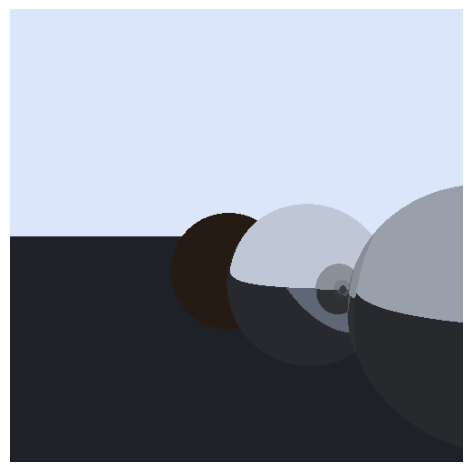

In [31]:
import numpy as np
import matplotlib.pyplot as plt

class Sphere:
    def __init__(self, center, radius, color, specular=0, reflective=0):
        self.center = np.array(center)
        self.radius = radius
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective

    def intersects(self, ray_origin, ray_direction):
        oc = ray_origin - self.center
        a = np.dot(ray_direction, ray_direction)
        b = 2 * np.dot(oc, ray_direction)
        c = np.dot(oc, oc) - self.radius ** 2
        discriminant = b ** 2 - 4 * a * c

        if discriminant < 0:
            return None, None

        t1 = (-b - np.sqrt(discriminant)) / (2 * a)
        t2 = (-b + np.sqrt(discriminant)) / (2 * a)
        return t1, t2

class Plane:
    def __init__(self, point, normal, color, specular=0, reflective=0):
        self.point = np.array(point)
        self.normal = np.array(normal) / np.linalg.norm(normal)
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective

    def intersects(self, ray_origin, ray_direction):
        denom = np.dot(ray_direction, self.normal)
        if abs(denom) < 1e-6:
            return None  
        t = np.dot(self.point - ray_origin, self.normal) / denom
        return t if t > 0 else None

def closest_intersection(ray_origin, ray_direction, t_min, t_max, objects):
    closest_t = float('inf')
    closest_obj = None

    for obj in objects:
        if isinstance(obj, Sphere):
            t1, t2 = obj.intersects(ray_origin, ray_direction)
            if t1 is not None and t_min < t1 < t_max and t1 < closest_t:
                closest_t = t1
                closest_obj = obj
            if t2 is not None and t_min < t2 < t_max and t2 < closest_t:
                closest_t = t2
                closest_obj = obj
        elif isinstance(obj, Plane):
            t = obj.intersects(ray_origin, ray_direction)
            if t is not None and t_min < t < t_max and t < closest_t:
                closest_t = t
                closest_obj = obj

    return closest_obj, closest_t

def compute_lighting(point, normal, view, specular, lights, objects):
    intensity = 0.0

    for light in lights:
        if light['type'] == 'ambient':
            intensity += light['intensity']
        else:
            light_dir = light['direction'] if light['type'] == 'directional' else light['position'] - point
            light_dir = light_dir / np.linalg.norm(light_dir)

            # Shadow Check (Fix: Increased bias to avoid self-shadowing)
            shadow_obj, _ = closest_intersection(point, light_dir, 0.01, float('inf'), objects)
            if shadow_obj is not None:
                continue  # If in shadow, ignore this light

            # Diffuse Lighting
            n_dot_l = np.dot(normal, light_dir)
            if n_dot_l > 0:
                intensity += light['intensity'] * n_dot_l

            # Specular Lighting
            if specular != -1:
                reflection = 2 * normal * np.dot(normal, light_dir) - light_dir
                r_dot_v = np.dot(reflection, view)
                if r_dot_v > 0:
                    intensity += light['intensity'] * (r_dot_v ** specular)

    return np.clip(intensity, 0, 1)  # Keep within valid intensity range

def trace_ray(ray_origin, ray_direction, t_min, t_max, objects, lights, recursion_depth):
    closest_obj, closest_t = closest_intersection(ray_origin, ray_direction, t_min, t_max, objects)
    if closest_obj is None:
        return np.array([220, 230, 250])  # Light blue background

    point = ray_origin + closest_t * ray_direction
    normal = (point - closest_obj.center) / closest_obj.radius if isinstance(closest_obj, Sphere) else closest_obj.normal
    view = -ray_direction

    lighting = compute_lighting(point, normal, view, closest_obj.specular, lights, objects)
    local_color = closest_obj.color * lighting

    reflectiveness = closest_obj.reflective
    if recursion_depth <= 0 or reflectiveness <= 0:
        return np.clip(local_color, 0, 255)

    reflection_direction = ray_direction - 2 * np.dot(ray_direction, normal) * normal
    reflection_color = trace_ray(point, reflection_direction, 0.01, float('inf'), objects, lights, recursion_depth - 1)

    final_color = (1 - reflectiveness) * local_color + reflectiveness * reflection_color
    return np.clip(final_color, 0, 255)

def render_image(width, height, viewport_size, projection_plane_d, objects, lights, camera_position, camera_rotation):
    image = np.zeros((height, width, 3), dtype=np.uint8)
    rotation_matrix = np.array([[np.cos(np.radians(camera_rotation[1])), 0, np.sin(np.radians(camera_rotation[1]))],
                                [0, 1, 0],
                                [-np.sin(np.radians(camera_rotation[1])), 0, np.cos(np.radians(camera_rotation[1]))]])

    for x in range(width):
        for y in range(height):
            px = (x - width / 2) * viewport_size / width
            py = -(y - height / 2) * viewport_size / height
            ray_direction = np.array([px, py, projection_plane_d])
            ray_direction = rotation_matrix @ ray_direction
            ray_direction = ray_direction / np.linalg.norm(ray_direction)

            color = trace_ray(camera_position, ray_direction, 0.001, float('inf'), objects, lights, recursion_depth=3)
            image[y, x] = color

    return image

if __name__ == "__main__":
    width, height = 500, 500
    camera_position = np.array([24, 8, -16])
    camera_rotation = (11, -65, 0)

    objects = [
        Sphere((12, 5, 0), 5, (181, 181, 181), 500, 0.6),
        Sphere((0, 5, 0), 5, (255, 255, 255), 2000, 0.8),
        Sphere((-12, 5, 0), 5, (129, 90, 60), 0, 0),
        Plane((0, 0, 0), (0, 1, 0), (100, 110, 130), 0, 0)
    ]

    lights = [
        {'type': 'ambient', 'intensity': 0.3},  
        {'type': 'directional', 'intensity': 0.7, 'direction': np.array([0.6, -0.54, 0.34])}
    ]

    image = render_image(width, height, 1.0, 1.0, objects, lights, camera_position, camera_rotation)

    plt.figure(figsize=(6, 6), dpi=100)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


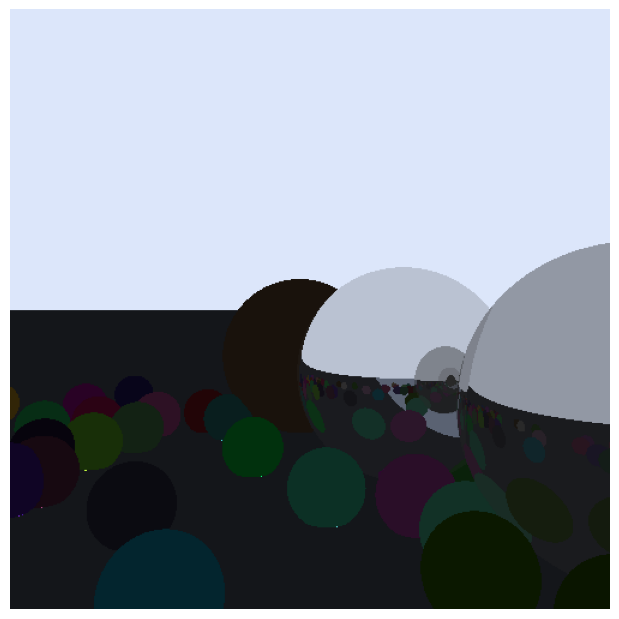

In [33]:
import numpy as np
import matplotlib.pyplot as plt

class Sphere:
    def __init__(self, center, radius, color, specular=0, reflective=0):
        self.center = np.array(center)
        self.radius = radius
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective

    def intersects(self, ray_origin, ray_direction):
        oc = ray_origin - self.center
        a = np.dot(ray_direction, ray_direction)
        b = 2 * np.dot(oc, ray_direction)
        c = np.dot(oc, oc) - self.radius ** 2
        discriminant = b ** 2 - 4 * a * c

        if discriminant < 0:
            return None, None

        t1 = (-b - np.sqrt(discriminant)) / (2 * a)
        t2 = (-b + np.sqrt(discriminant)) / (2 * a)
        return t1, t2

class Plane:
    def __init__(self, point, normal, color, specular=0, reflective=0):
        self.point = np.array(point)
        self.normal = np.array(normal) / np.linalg.norm(normal)
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective

    def intersects(self, ray_origin, ray_direction):
        denom = np.dot(ray_direction, self.normal)
        if abs(denom) < 1e-6:
            return None  # No intersection, the ray is parallel to the plane
        t = np.dot(self.point - ray_origin, self.normal) / denom
        return t if t > 0 else None

def closest_intersection(ray_origin, ray_direction, t_min, t_max, objects):
    closest_t = float('inf')
    closest_obj = None

    for obj in objects:
        if isinstance(obj, Sphere):
            t1, t2 = obj.intersects(ray_origin, ray_direction)
            if t1 is not None and t_min < t1 < t_max and t1 < closest_t:
                closest_t = t1
                closest_obj = obj
            if t2 is not None and t_min < t2 < t_max and t2 < closest_t:
                closest_t = t2
                closest_obj = obj
        elif isinstance(obj, Plane):
            t = obj.intersects(ray_origin, ray_direction)
            if t is not None and t_min < t < t_max and t < closest_t:
                closest_t = t
                closest_obj = obj

    return closest_obj, closest_t

def compute_lighting(point, normal, view, specular, lights, objects):
    intensity = 0.0

    for light in lights:
        if light['type'] == 'ambient':
            intensity += light['intensity']
        else:
            light_dir = light['direction'] if light['type'] == 'directional' else light['position'] - point
            light_dir = light_dir / np.linalg.norm(light_dir)
            
            shadow_obj, shadow_t = closest_intersection(point, light_dir, 0.01, float('inf'), objects)
            if shadow_obj is not None:
                continue
            
            n_dot_l = np.dot(normal, light_dir)
            if n_dot_l > 0:
                intensity += light['intensity'] * n_dot_l

            if specular != -1:
                reflection = 2 * normal * np.dot(normal, light_dir) - light_dir
                r_dot_v = np.dot(reflection, view)
                if r_dot_v > 0:
                    intensity += light['intensity'] * (r_dot_v ** specular)

    return intensity

def trace_ray(ray_origin, ray_direction, t_min, t_max, objects, lights, recursion_depth):
    closest_obj, closest_t = closest_intersection(ray_origin, ray_direction, t_min, t_max, objects)
    if closest_obj is None:
        return np.array([220, 230, 250])

    point = ray_origin + closest_t * ray_direction
    normal = (point - closest_obj.center) / closest_obj.radius if isinstance(closest_obj, Sphere) else closest_obj.normal
    view = -ray_direction

    lighting = compute_lighting(point, normal, view, closest_obj.specular, lights, objects)
    local_color = closest_obj.color * lighting

    reflectiveness = closest_obj.reflective
    if recursion_depth <= 0 or reflectiveness <= 0:
        return np.clip(local_color, 0, 255)

    reflection_direction = ray_direction - 2 * np.dot(ray_direction, normal) * normal
    reflection_color = trace_ray(point, reflection_direction, 0.001, float('inf'), objects, lights, recursion_depth - 1)

    final_color = (1 - reflectiveness) * local_color + reflectiveness * reflection_color
    return np.clip(final_color, 0, 255)

def render_image(width, height, viewport_size, projection_plane_d, objects, lights, camera_position, camera_rotation):
    image = np.zeros((height, width, 3), dtype=np.uint8)
    rotation_matrix = np.array([[np.cos(np.radians(camera_rotation[1])), 0, np.sin(np.radians(camera_rotation[1]))],
                                [0, 1, 0],
                                [-np.sin(np.radians(camera_rotation[1])), 0, np.cos(np.radians(camera_rotation[1]))]])
    
    for x in range(width):
        for y in range(height):
            px = (x - width / 2) * viewport_size / width
            py = -(y - height / 2) * viewport_size / height
            ray_direction = np.array([px, py, projection_plane_d])
            ray_direction = rotation_matrix @ ray_direction
            ray_direction = ray_direction / np.linalg.norm(ray_direction)

            color = trace_ray(camera_position, ray_direction, 0.001, float('inf'), objects, lights, recursion_depth=3)
            image[y, x] = color

    return image

if __name__ == "__main__":
    width, height = 500, 500
    camera_position = np.array([24, 8, -16])
    camera_rotation = (11, -65, 0)
    
    objects = [
        Sphere((12, 5, 0), 5, (181, 181, 181), 500, 0.6),
        Sphere((0, 5, 0), 5, (255, 255, 255), 2000, 0.8),
        Sphere((-12, 5, 0), 5, (129, 90, 60), 0, 0),
        Plane((0, 0, 0), (0, 1, 0), (100, 110, 130), 0, 0)
    ]
    
    # Random small spheres
    np.random.seed(42)  # For reproducibility
    small_spheres = []
    for _ in range(100):
        x, z = np.random.uniform(-30, 30, 2)
        color = np.random.randint(0, 256, 3)
        small_spheres.append(Sphere(center=(x, 1.2, z), radius=1.5, color=color))

    lights = [
        {'type': 'ambient', 'intensity': 0.2},  # Reduced ambient intensity
        {'type': 'directional', 'intensity': 0.8, 'direction': np.array([0.6, -0.54, 0.34])}
    ]
    
    objects = objects + small_spheres

    image = render_image(width, height, 1.0, 1.0, objects, lights, camera_position, camera_rotation)
    # Display the image
    plt.figure(figsize=(6, 6), dpi=100)
    plt.imshow(image)
    plt.axis('off')
    plt.gca().set_position([0, 0, 1, 1])
    plt.show()

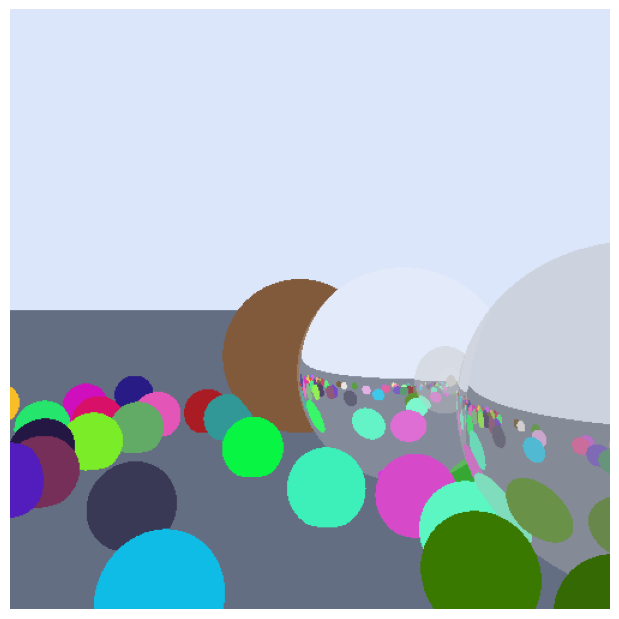

In [34]:
import numpy as np
import matplotlib.pyplot as plt

class Sphere:
    def __init__(self, center, radius, color, specular=0, reflective=0):
        self.center = np.array(center)
        self.radius = radius
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective

    def intersects(self, ray_origin, ray_direction):
        oc = ray_origin - self.center
        a = np.dot(ray_direction, ray_direction)
        b = 2 * np.dot(oc, ray_direction)
        c = np.dot(oc, oc) - self.radius ** 2
        discriminant = b ** 2 - 4 * a * c

        if discriminant < 0:
            return None, None

        t1 = (-b - np.sqrt(discriminant)) / (2 * a)
        t2 = (-b + np.sqrt(discriminant)) / (2 * a)
        return t1, t2

class Plane:
    def __init__(self, point, normal, color, specular=0, reflective=0):
        self.point = np.array(point)
        self.normal = np.array(normal) / np.linalg.norm(normal)
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective

    def intersects(self, ray_origin, ray_direction):
        denom = np.dot(ray_direction, self.normal)
        if abs(denom) < 1e-6:
            return None  # No intersection, the ray is parallel to the plane
        t = np.dot(self.point - ray_origin, self.normal) / denom
        return t if t > 0 else None

def closest_intersection(ray_origin, ray_direction, t_min, t_max, objects):
    closest_t = float('inf')
    closest_obj = None

    for obj in objects:
        if isinstance(obj, Sphere):
            t1, t2 = obj.intersects(ray_origin, ray_direction)
            if t1 is not None and t_min < t1 < t_max and t1 < closest_t:
                closest_t = t1
                closest_obj = obj
            if t2 is not None and t_min < t2 < t_max and t2 < closest_t:
                closest_t = t2
                closest_obj = obj
        elif isinstance(obj, Plane):
            t = obj.intersects(ray_origin, ray_direction)
            if t is not None and t_min < t < t_max and t < closest_t:
                closest_t = t
                closest_obj = obj

    return closest_obj, closest_t

def compute_lighting(point, normal, view, specular, lights, objects):
    intensity = 0.0

    for light in lights:
        if light['type'] == 'ambient':
            intensity += light['intensity']
        else:
            light_dir = light['direction'] if light['type'] == 'directional' else light['position'] - point
            light_dir = light_dir / np.linalg.norm(light_dir)
            
            shadow_obj, shadow_t = closest_intersection(point, light_dir, 0.001, float('inf'), objects)
            if shadow_obj is not None and shadow_t > 0.001:
                continue
            
            n_dot_l = np.dot(normal, light_dir)
            if n_dot_l > 0:
                intensity += light['intensity'] * n_dot_l

            if specular > 0:
                reflection = 2 * normal * np.dot(normal, light_dir) - light_dir
                reflection = reflection / np.linalg.norm(reflection)
                r_dot_v = np.dot(reflection, view)
                if r_dot_v > 0:
                    intensity += light['intensity'] * (r_dot_v ** specular)

    return intensity

def trace_ray(ray_origin, ray_direction, t_min, t_max, objects, lights, recursion_depth):
    closest_obj, closest_t = closest_intersection(ray_origin, ray_direction, t_min, t_max, objects)
    if closest_obj is None:
        return np.array([220, 230, 250])

    point = ray_origin + closest_t * ray_direction
    normal = (point - closest_obj.center) / closest_obj.radius if isinstance(closest_obj, Sphere) else closest_obj.normal
    normal = normal / np.linalg.norm(normal)
    view = -ray_direction

    lighting = compute_lighting(point, normal, view, closest_obj.specular, lights, objects)
    local_color = closest_obj.color * lighting

    reflectiveness = closest_obj.reflective
    if recursion_depth <= 0 or reflectiveness <= 0:
        return np.clip(local_color, 0, 255)

    reflection_direction = ray_direction - 2 * np.dot(ray_direction, normal) * normal
    reflection_direction = reflection_direction / np.linalg.norm(reflection_direction)
    reflection_color = trace_ray(point, reflection_direction, 0.001, float('inf'), objects, lights, recursion_depth - 1)

    final_color = (1 - reflectiveness) * local_color + reflectiveness * reflection_color
    return np.clip(final_color, 0, 255)

def render_image(width, height, viewport_size, projection_plane_d, objects, lights, camera_position, camera_rotation):
    image = np.zeros((height, width, 3), dtype=np.uint8)
    rotation_matrix = np.array([[np.cos(np.radians(camera_rotation[1])), 0, np.sin(np.radians(camera_rotation[1]))],
                                [0, 1, 0],
                                [-np.sin(np.radians(camera_rotation[1])), 0, np.cos(np.radians(camera_rotation[1]))]])
    
    for x in range(width):
        for y in range(height):
            px = (x - width / 2) * viewport_size / width
            py = -(y - height / 2) * viewport_size / height
            ray_direction = np.array([px, py, projection_plane_d])
            ray_direction = rotation_matrix @ ray_direction
            ray_direction = ray_direction / np.linalg.norm(ray_direction)

            color = trace_ray(camera_position, ray_direction, 0.001, float('inf'), objects, lights, recursion_depth=3)
            image[y, x] = color

    return image

if __name__ == "__main__":
    width, height = 500, 500
    camera_position = np.array([24, 8, -16])
    camera_rotation = (11, -65, 0)
    
    objects = [
        Sphere((12, 5, 0), 5, (181, 181, 181), 500, 0.6),
        Sphere((0, 5, 0), 5, (255, 255, 255), 2000, 0.8),
        Sphere((-12, 5, 0), 5, (129, 90, 60), 0, 0),
        Plane((0, 0, 0), (0, 1, 0), (100, 110, 130), 0, 0)
    ]
    
    # Random small spheres
    np.random.seed(42)  # For reproducibility
    small_spheres = []
    for _ in range(100):
        x, z = np.random.uniform(-30, 30, 2)
        color = np.random.randint(0, 256, 3)
        small_spheres.append(Sphere(center=(x, 1.2, z), radius=1.5, color=color))


    lights = [{'type': 'ambient', 'intensity': 1},
              {'type': 'directional', 'intensity': 0.8, 'direction': np.array([0.6, -0.54, 0.34])}]
    
    objects = objects + small_spheres

    image = render_image(width, height, 1.0, 1.0, objects, lights, camera_position, camera_rotation)
    # Display the image
    plt.figure(figsize=(6, 6), dpi=100)
    plt.imshow(image)
    plt.axis('off')
    plt.gca().set_position([0, 0, 1, 1])
    plt.show()

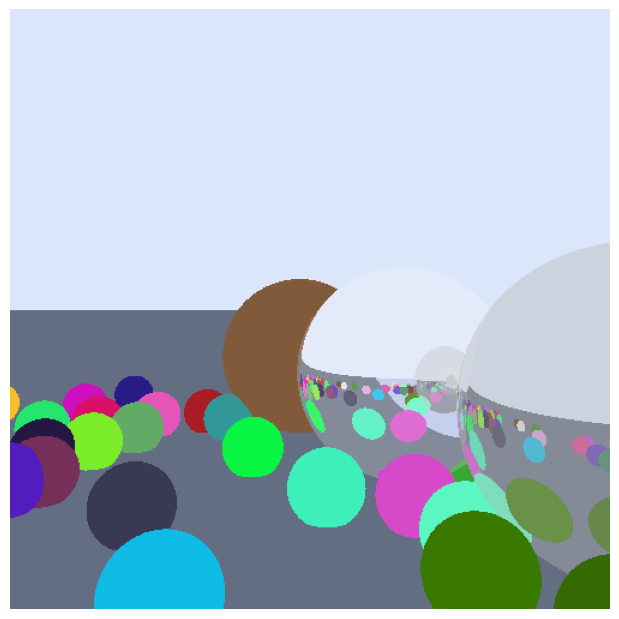

In [35]:
import numpy as np
import matplotlib.pyplot as plt

class Sphere:
    def __init__(self, center, radius, color, specular=0, reflective=0):
        self.center = np.array(center)
        self.radius = radius
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective

    def intersects(self, ray_origin, ray_direction):
        oc = ray_origin - self.center
        a = np.dot(ray_direction, ray_direction)
        b = 2 * np.dot(oc, ray_direction)
        c = np.dot(oc, oc) - self.radius ** 2
        discriminant = b ** 2 - 4 * a * c

        if discriminant < 0:
            return None, None

        t1 = (-b - np.sqrt(discriminant)) / (2 * a)
        t2 = (-b + np.sqrt(discriminant)) / (2 * a)
        return t1, t2

class Plane:
    def __init__(self, point, normal, color, specular=0, reflective=0):
        self.point = np.array(point)
        self.normal = np.array(normal) / np.linalg.norm(normal)
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective

    def intersects(self, ray_origin, ray_direction):
        denom = np.dot(ray_direction, self.normal)
        if abs(denom) < 1e-6:
            return None  # No intersection, the ray is parallel to the plane
        t = np.dot(self.point - ray_origin, self.normal) / denom
        return t if t > 0 else None

def closest_intersection(ray_origin, ray_direction, t_min, t_max, objects):
    closest_t = float('inf')
    closest_obj = None

    for obj in objects:
        if isinstance(obj, Sphere):
            t1, t2 = obj.intersects(ray_origin, ray_direction)
            if t1 is not None and t_min < t1 < t_max and t1 < closest_t:
                closest_t = t1
                closest_obj = obj
            if t2 is not None and t_min < t2 < t_max and t2 < closest_t:
                closest_t = t2
                closest_obj = obj
        elif isinstance(obj, Plane):
            t = obj.intersects(ray_origin, ray_direction)
            if t is not None and t_min < t < t_max and t < closest_t:
                closest_t = t
                closest_obj = obj

    return closest_obj, closest_t

def compute_lighting(point, normal, view, specular, lights, objects):
    intensity = 0.0

    for light in lights:
        if light['type'] == 'ambient':
            intensity += light['intensity']
        else:
            light_dir = light['direction'] if light['type'] == 'directional' else light['position'] - point
            light_dir = light_dir / np.linalg.norm(light_dir)
            
            shadow_obj, shadow_t = closest_intersection(point, light_dir, 0.001, float('inf'), objects)
            if shadow_obj is not None:
                continue
            
            n_dot_l = np.dot(normal, light_dir)
            if n_dot_l > 0:
                intensity += light['intensity'] * n_dot_l

            if specular != -1:
                reflection = 2 * normal * np.dot(normal, light_dir) - light_dir
                r_dot_v = np.dot(reflection, view)
                if r_dot_v > 0:
                    intensity += light['intensity'] * (r_dot_v ** specular)

    return intensity

def trace_ray(ray_origin, ray_direction, t_min, t_max, objects, lights, recursion_depth):
    closest_obj, closest_t = closest_intersection(ray_origin, ray_direction, t_min, t_max, objects)
    if closest_obj is None:
        return np.array([220, 230, 250])

    point = ray_origin + closest_t * ray_direction
    normal = (point - closest_obj.center) / closest_obj.radius if isinstance(closest_obj, Sphere) else closest_obj.normal
    view = -ray_direction

    lighting = compute_lighting(point, normal, view, closest_obj.specular, lights, objects)
    local_color = closest_obj.color * lighting

    reflectiveness = closest_obj.reflective
    if recursion_depth <= 0 or reflectiveness <= 0:
        return np.clip(local_color, 0, 255)

    reflection_direction = ray_direction - 2 * np.dot(ray_direction, normal) * normal
    reflection_color = trace_ray(point, reflection_direction, 0.001, float('inf'), objects, lights, recursion_depth - 1)

    final_color = (1 - reflectiveness) * local_color + reflectiveness * reflection_color
    return np.clip(final_color, 0, 255)

def render_image(width, height, viewport_size, projection_plane_d, objects, lights, camera_position, camera_rotation):
    image = np.zeros((height, width, 3), dtype=np.uint8)
    rotation_matrix = np.array([[np.cos(np.radians(camera_rotation[1])), 0, np.sin(np.radians(camera_rotation[1]))],
                                [0, 1, 0],
                                [-np.sin(np.radians(camera_rotation[1])), 0, np.cos(np.radians(camera_rotation[1]))]])
    
    for x in range(width):
        for y in range(height):
            px = (x - width / 2) * viewport_size / width
            py = -(y - height / 2) * viewport_size / height
            ray_direction = np.array([px, py, projection_plane_d])
            ray_direction = rotation_matrix @ ray_direction
            ray_direction = ray_direction / np.linalg.norm(ray_direction)

            color = trace_ray(camera_position, ray_direction, 0.001, float('inf'), objects, lights, recursion_depth=3)
            image[y, x] = color

    return image

if __name__ == "__main__":
    width, height = 500, 500
    camera_position = np.array([24, 8, -16])
    camera_rotation = (11, -65, 0)
    
    objects = [
        Sphere((12, 5, 0), 5, (181, 181, 181), 500, 0.6),
        Sphere((0, 5, 0), 5, (255, 255, 255), 2000, 0.8),
        Sphere((-12, 5, 0), 5, (129, 90, 60), 0, 0),
        Plane((0, 0, 0), (0, 1, 0), (100, 110, 130), 0, 0)
    ]
    
    # Random small spheres
    np.random.seed(42)  # For reproducibility
    small_spheres = []
    for _ in range(100):
        x, z = np.random.uniform(-30, 30, 2)
        color = np.random.randint(0, 256, 3)
        small_spheres.append(Sphere(center=(x, 1.2, z), radius=1.5, color=color))


    lights = [{'type': 'ambient', 'intensity': 1},
              {'type': 'directional', 'intensity': 0.8, 'direction': np.array([0.6, -0.54, 0.34])}]
    
    objects = objects + small_spheres

    image = render_image(width, height, 1.0, 1.0, objects, lights, camera_position, camera_rotation)
    # Display the image
    plt.figure(figsize=(6, 6), dpi=100)
    plt.imshow(image)
    plt.axis('off')
    plt.gca().set_position([0, 0, 1, 1])
    plt.show()

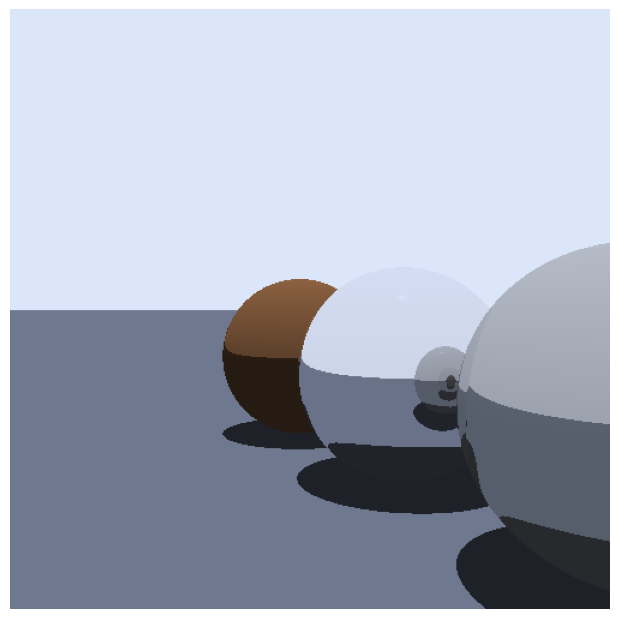

In [47]:
import numpy as np
import matplotlib.pyplot as plt

class Sphere:
    def __init__(self, center, radius, color, specular=0, reflective=0):
        self.center = np.array(center)
        self.radius = radius
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective

    def intersects(self, ray_origin, ray_direction):
        oc = ray_origin - self.center
        a = np.dot(ray_direction, ray_direction)
        b = 2 * np.dot(oc, ray_direction)
        c = np.dot(oc, oc) - self.radius ** 2
        discriminant = b ** 2 - 4 * a * c

        if discriminant < 0:
            return None, None

        t1 = (-b - np.sqrt(discriminant)) / (2 * a)
        t2 = (-b + np.sqrt(discriminant)) / (2 * a)
        return t1, t2

class Plane:
    def __init__(self, point, normal, color, specular=0, reflective=0):
        self.point = np.array(point)
        self.normal = np.array(normal) / np.linalg.norm(normal)
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective

    def intersects(self, ray_origin, ray_direction):
        denom = np.dot(ray_direction, self.normal)
        if abs(denom) < 1e-6:
            return None
        t = np.dot(self.point - ray_origin, self.normal) / denom
        return t if t > 0 else None

def closest_intersection(ray_origin, ray_direction, t_min, t_max, objects):
    closest_t = float('inf')
    closest_obj = None

    for obj in objects:
        if isinstance(obj, Sphere):
            t1, t2 = obj.intersects(ray_origin, ray_direction)
            if t1 is not None and t_min < t1 < t_max and t1 < closest_t:
                closest_t = t1
                closest_obj = obj
            if t2 is not None and t_min < t2 < t_max and t2 < closest_t:
                closest_t = t2
                closest_obj = obj
        elif isinstance(obj, Plane):
            t = obj.intersects(ray_origin, ray_direction)
            if t is not None and t_min < t < t_max and t < closest_t:
                closest_t = t
                closest_obj = obj

    return closest_obj, closest_t

def compute_lighting(point, normal, view, specular, lights, spheres):
    intensity = 0.0

    for light in lights:
        if light['type'] == 'ambient':
            intensity += light['intensity']
        else:
            if light['type'] == 'point':
                light_dir = light['position'] - point
                t_max = 1
            elif light['type'] == 'directional':
                light_dir = light['direction']
                t_max = float('inf')

            light_dir = light_dir / np.linalg.norm(light_dir)

            shadow_sphere, shadow_t = closest_intersection(point, light_dir, 0.001, t_max, spheres)
            if shadow_sphere is not None:
                continue

            n_dot_l = np.dot(normal, light_dir)
            if n_dot_l > 0:
                intensity += light['intensity'] * n_dot_l

            if specular != -1:
                reflection = 2 * normal * np.dot(normal, light_dir) - light_dir
                r_dot_v = np.dot(reflection, view)
                if r_dot_v > 0:
                    intensity += light['intensity'] * (r_dot_v ** specular)

    return intensity

def trace_ray(ray_origin, ray_direction, t_min, t_max, objects, lights, recursion_depth):
    closest_obj, closest_t = closest_intersection(ray_origin, ray_direction, t_min, t_max, objects)
    if closest_obj is None:
        return np.array([220, 230, 250])

    point = ray_origin + closest_t * ray_direction
    normal = (point - closest_obj.center) / closest_obj.radius if isinstance(closest_obj, Sphere) else closest_obj.normal
    view = -ray_direction

    lighting = compute_lighting(point, normal, view, closest_obj.specular, lights, objects)
    local_color = closest_obj.color * lighting

    reflectiveness = closest_obj.reflective
    if recursion_depth <= 0 or reflectiveness <= 0:
        return np.clip(local_color, 0, 255)

    reflection_direction = ray_direction - 2 * np.dot(ray_direction, normal) * normal
    reflection_color = trace_ray(point, reflection_direction, 0.001, float('inf'), objects, lights, recursion_depth - 1)

    final_color = (1 - reflectiveness) * local_color + reflectiveness * reflection_color
    return np.clip(final_color, 0, 255)

def render_image(width, height, viewport_size, projection_plane_d, objects, lights, camera_position, camera_rotation):
    image = np.zeros((height, width, 3), dtype=np.uint8)
    rotation_matrix = np.array([[np.cos(np.radians(camera_rotation[1])), 0, np.sin(np.radians(camera_rotation[1]))],
                                [0, 1, 0],
                                [-np.sin(np.radians(camera_rotation[1])), 0, np.cos(np.radians(camera_rotation[1]))]])
    
    for x in range(width):
        for y in range(height):
            px = (x - width / 2) * viewport_size / width
            py = -(y - height / 2) * viewport_size / height
            ray_direction = np.array([px, py, projection_plane_d])
            ray_direction = rotation_matrix @ ray_direction
            ray_direction = ray_direction / np.linalg.norm(ray_direction)

            color = trace_ray(camera_position, ray_direction, 0.001, float('inf'), objects, lights, recursion_depth=3)
            image[y, x] = color

    return image

if __name__ == "__main__":
    width, height = 500, 500
    camera_position = np.array([24, 8, -16])
    camera_rotation = (11, -65, 0)
    
    objects = [
        Sphere((12, 5, 0), 5, (181, 181, 181), 500, 0.6),
        Sphere((0, 5, 0), 5, (200, 200, 255), 500, 0.9),
        Sphere((-12, 5, 0), 5, (129, 90, 60), 0, 0),
        Plane((0, 0, 0), (0, 1, 0), (100, 110, 130), 0, 0)
    ]
    
    lights = [
        {'type': 'ambient', 'intensity': 0.3},
        {'type': 'point', 'intensity': 0, 'position': np.array([0, 0, 0])},
        {'type': 'directional', 'intensity': 0.4, 'direction': np.array([0, 3, 0])}
    ]
    
    image = render_image(width, height, 1.0, 1.0, objects, lights, camera_position, camera_rotation)
    plt.figure(figsize=(6, 6), dpi=100)
    plt.imshow(image)
    plt.axis('off')
    plt.gca().set_position([0, 0, 1, 1])
    plt.show()


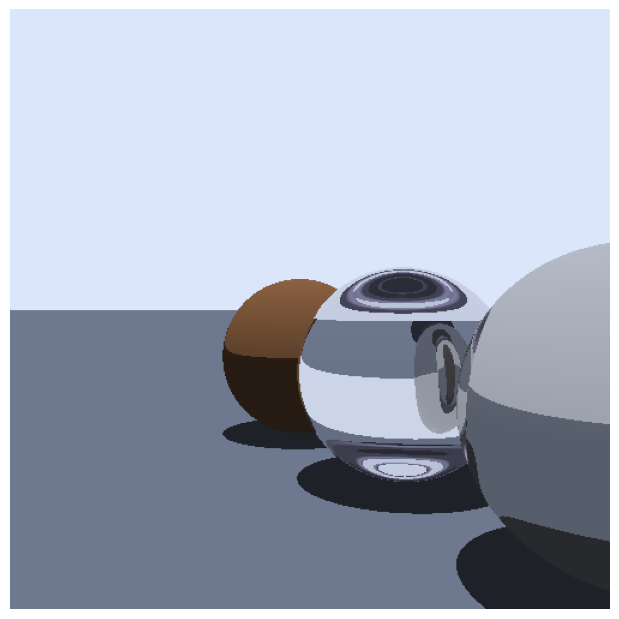

In [49]:
import numpy as np
import matplotlib.pyplot as plt

class Sphere:
    def __init__(self, center, radius, color, specular=0, reflective=0, inverse_reflection=False):
        self.center = np.array(center)
        self.radius = radius
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective
        self.inverse_reflection = inverse_reflection  # New attribute to control inverse reflection

    def intersects(self, ray_origin, ray_direction):
        oc = ray_origin - self.center
        a = np.dot(ray_direction, ray_direction)
        b = 2 * np.dot(oc, ray_direction)
        c = np.dot(oc, oc) - self.radius ** 2
        discriminant = b ** 2 - 4 * a * c

        if discriminant < 0:
            return None, None

        t1 = (-b - np.sqrt(discriminant)) / (2 * a)
        t2 = (-b + np.sqrt(discriminant)) / (2 * a)
        return t1, t2

class Plane:
    def __init__(self, point, normal, color, specular=0, reflective=0):
        self.point = np.array(point)
        self.normal = np.array(normal) / np.linalg.norm(normal)
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective

    def intersects(self, ray_origin, ray_direction):
        denom = np.dot(ray_direction, self.normal)
        if abs(denom) < 1e-6:
            return None
        t = np.dot(self.point - ray_origin, self.normal) / denom
        return t if t > 0 else None

def closest_intersection(ray_origin, ray_direction, t_min, t_max, objects):
    closest_t = float('inf')
    closest_obj = None

    for obj in objects:
        if isinstance(obj, Sphere):
            t1, t2 = obj.intersects(ray_origin, ray_direction)
            if t1 is not None and t_min < t1 < t_max and t1 < closest_t:
                closest_t = t1
                closest_obj = obj
            if t2 is not None and t_min < t2 < t_max and t2 < closest_t:
                closest_t = t2
                closest_obj = obj
        elif isinstance(obj, Plane):
            t = obj.intersects(ray_origin, ray_direction)
            if t is not None and t_min < t < t_max and t < closest_t:
                closest_t = t
                closest_obj = obj

    return closest_obj, closest_t

def compute_lighting(point, normal, view, specular, lights, spheres):
    intensity = 0.0

    for light in lights:
        if light['type'] == 'ambient':
            intensity += light['intensity']
        else:
            if light['type'] == 'point':
                light_dir = light['position'] - point
                t_max = 1
            elif light['type'] == 'directional':
                light_dir = light['direction']
                t_max = float('inf')

            light_dir = light_dir / np.linalg.norm(light_dir)

            shadow_sphere, shadow_t = closest_intersection(point, light_dir, 0.001, t_max, spheres)
            if shadow_sphere is not None:
                continue

            n_dot_l = np.dot(normal, light_dir)
            if n_dot_l > 0:
                intensity += light['intensity'] * n_dot_l

            if specular != -1:
                reflection = 2 * normal * np.dot(normal, light_dir) - light_dir
                r_dot_v = np.dot(reflection, view)
                if r_dot_v > 0:
                    intensity += light['intensity'] * (r_dot_v ** specular)

    return intensity

def trace_ray(ray_origin, ray_direction, t_min, t_max, objects, lights, recursion_depth):
    closest_obj, closest_t = closest_intersection(ray_origin, ray_direction, t_min, t_max, objects)
    if closest_obj is None:
        return np.array([220, 230, 250])

    point = ray_origin + closest_t * ray_direction
    normal = (point - closest_obj.center) / closest_obj.radius if isinstance(closest_obj, Sphere) else closest_obj.normal
    view = -ray_direction

    lighting = compute_lighting(point, normal, view, closest_obj.specular, lights, objects)
    local_color = closest_obj.color * lighting

    reflectiveness = closest_obj.reflective
    if recursion_depth <= 0 or reflectiveness <= 0:
        return np.clip(local_color, 0, 255)

    # Check if this sphere should use inverse reflection
    reflection_direction = ray_direction - 2 * np.dot(ray_direction, normal) * normal
    if closest_obj.inverse_reflection:  # Apply the inverse reflection logic here
        reflection_direction[1] = -reflection_direction[1]  # Flip the Y-component only if inverse reflection is set

    reflection_color = trace_ray(point, reflection_direction, 0.001, float('inf'), objects, lights, recursion_depth - 1)

    final_color = (1 - reflectiveness) * local_color + reflectiveness * reflection_color
    return np.clip(final_color, 0, 255)

def render_image(width, height, viewport_size, projection_plane_d, objects, lights, camera_position, camera_rotation):
    image = np.zeros((height, width, 3), dtype=np.uint8)
    rotation_matrix = np.array([[np.cos(np.radians(camera_rotation[1])), 0, np.sin(np.radians(camera_rotation[1]))],
                                [0, 1, 0],
                                [-np.sin(np.radians(camera_rotation[1])), 0, np.cos(np.radians(camera_rotation[1]))]])
    
    for x in range(width):
        for y in range(height):
            px = (x - width / 2) * viewport_size / width
            py = -(y - height / 2) * viewport_size / height
            ray_direction = np.array([px, py, projection_plane_d])
            ray_direction = rotation_matrix @ ray_direction
            ray_direction = ray_direction / np.linalg.norm(ray_direction)

            color = trace_ray(camera_position, ray_direction, 0.001, float('inf'), objects, lights, recursion_depth=3)
            image[y, x] = color

    return image

if __name__ == "__main__":
    width, height = 500, 500
    camera_position = np.array([24, 8, -16])
    camera_rotation = (11, -65, 0)
    
    objects = [
        Sphere((12, 5, 0), 5, (181, 181, 181), 500, 0.6),  # Normal sphere
        Sphere((0, 5, 0), 5, (200, 200, 255), 500, 0.9, inverse_reflection=True),  # Inverse reflection sphere
        Sphere((-12, 5, 0), 5, (129, 90, 60), 0, 0),
        Plane((0, 0, 0), (0, 1, 0), (100, 110, 130), 0, 0)
    ]
    
    lights = [
        {'type': 'ambient', 'intensity': 0.3},
        {'type': 'point', 'intensity': 0, 'position': np.array([0, 0, 0])},
        {'type': 'directional', 'intensity': 0.4, 'direction': np.array([0, 3, 0])}
    ]
    
    image = render_image(width, height, 1.0, 1.0, objects, lights, camera_position, camera_rotation)
    plt.figure(figsize=(6, 6), dpi=100)
    plt.imshow(image)
    plt.axis('off')
    plt.gca().set_position([0, 0, 1, 1])
    plt.show()


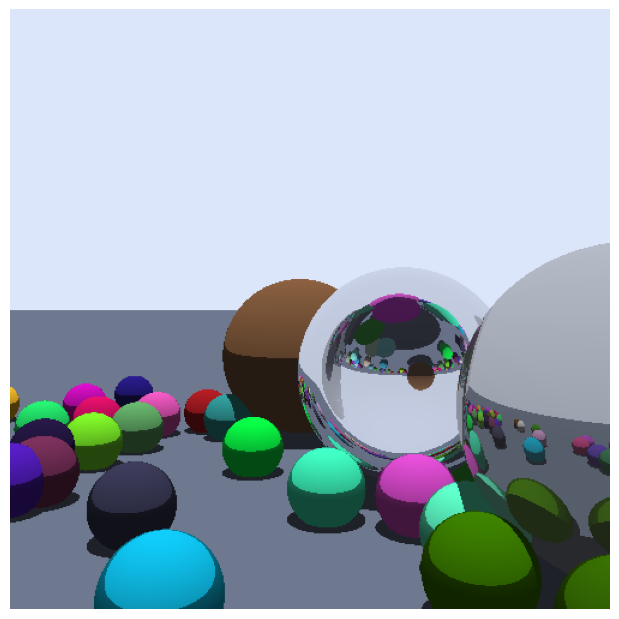

In [54]:
import numpy as np
import matplotlib.pyplot as plt

class Sphere:
    def __init__(self, center, radius, color, specular=0, reflective=0, inverse_reflection=False):
        self.center = np.array(center)
        self.radius = radius
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective
        self.inverse_reflection = inverse_reflection  # New attribute to control inverse reflection

    def intersects(self, ray_origin, ray_direction):
        oc = ray_origin - self.center
        a = np.dot(ray_direction, ray_direction)
        b = 2 * np.dot(oc, ray_direction)
        c = np.dot(oc, oc) - self.radius ** 2
        discriminant = b ** 2 - 4 * a * c

        if discriminant < 0:
            return None, None

        t1 = (-b - np.sqrt(discriminant)) / (2 * a)
        t2 = (-b + np.sqrt(discriminant)) / (2 * a)
        return t1, t2

class Plane:
    def __init__(self, point, normal, color, specular=0, reflective=0):
        self.point = np.array(point)
        self.normal = np.array(normal) / np.linalg.norm(normal)
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective

    def intersects(self, ray_origin, ray_direction):
        denom = np.dot(ray_direction, self.normal)
        if abs(denom) < 1e-6:
            return None
        t = np.dot(self.point - ray_origin, self.normal) / denom
        return t if t > 0 else None

def closest_intersection(ray_origin, ray_direction, t_min, t_max, objects):
    closest_t = float('inf')
    closest_obj = None

    for obj in objects:
        if isinstance(obj, Sphere):
            t1, t2 = obj.intersects(ray_origin, ray_direction)
            if t1 is not None and t_min < t1 < t_max and t1 < closest_t:
                closest_t = t1
                closest_obj = obj
            if t2 is not None and t_min < t2 < t_max and t2 < closest_t:
                closest_t = t2
                closest_obj = obj
        elif isinstance(obj, Plane):
            t = obj.intersects(ray_origin, ray_direction)
            if t is not None and t_min < t < t_max and t < closest_t:
                closest_t = t
                closest_obj = obj

    return closest_obj, closest_t

def compute_lighting(point, normal, view, specular, lights, spheres):
    intensity = 0.0

    for light in lights:
        if light['type'] == 'ambient':
            intensity += light['intensity']
        else:
            if light['type'] == 'point':
                light_dir = light['position'] - point
                t_max = 1
            elif light['type'] == 'directional':
                light_dir = light['direction']
                t_max = float('inf')

            light_dir = light_dir / np.linalg.norm(light_dir)

            shadow_sphere, shadow_t = closest_intersection(point, light_dir, 0.001, t_max, spheres)
            if shadow_sphere is not None:
                continue

            n_dot_l = np.dot(normal, light_dir)
            if n_dot_l > 0:
                intensity += light['intensity'] * n_dot_l

            if specular != -1:
                reflection = 2 * normal * np.dot(normal, light_dir) - light_dir
                r_dot_v = np.dot(reflection, view)
                if r_dot_v > 0:
                    intensity += light['intensity'] * (r_dot_v ** specular)

    return intensity

def trace_ray(ray_origin, ray_direction, t_min, t_max, objects, lights, recursion_depth):
    closest_obj, closest_t = closest_intersection(ray_origin, ray_direction, t_min, t_max, objects)
    if closest_obj is None:
        return np.array([220, 230, 250])

    point = ray_origin + closest_t * ray_direction
    normal = (point - closest_obj.center) / closest_obj.radius if isinstance(closest_obj, Sphere) else closest_obj.normal
    view = -ray_direction

    lighting = compute_lighting(point, normal, view, closest_obj.specular, lights, objects)
    local_color = closest_obj.color * lighting

    reflectiveness = closest_obj.reflective
    if recursion_depth <= 0 or reflectiveness <= 0:
        return np.clip(local_color, 0, 255)

    # Check if this sphere should use inverse reflection
    reflection_direction = ray_direction - 2 * np.dot(ray_direction, normal) * normal
    if closest_obj.inverse_reflection:  # Apply the inverse reflection logic here
        # Reflect the direction as if it hit the opposite hemisphere
        reflection_direction = -reflection_direction  # Inverse the reflection direction to simulate the opposite hemisphere

    reflection_color = trace_ray(point, reflection_direction, 0.001, float('inf'), objects, lights, recursion_depth - 1)

    final_color = (1 - reflectiveness) * local_color + reflectiveness * reflection_color
    return np.clip(final_color, 0, 255)

def render_image(width, height, viewport_size, projection_plane_d, objects, lights, camera_position, camera_rotation):
    image = np.zeros((height, width, 3), dtype=np.uint8)
    rotation_matrix = np.array([[np.cos(np.radians(camera_rotation[1])), 0, np.sin(np.radians(camera_rotation[1]))],
                                [0, 1, 0],
                                [-np.sin(np.radians(camera_rotation[1])), 0, np.cos(np.radians(camera_rotation[1]))]])
    
    for x in range(width):
        for y in range(height):
            px = (x - width / 2) * viewport_size / width
            py = -(y - height / 2) * viewport_size / height
            ray_direction = np.array([px, py, projection_plane_d])
            ray_direction = rotation_matrix @ ray_direction
            ray_direction = ray_direction / np.linalg.norm(ray_direction)

            color = trace_ray(camera_position, ray_direction, 0.001, float('inf'), objects, lights, recursion_depth=3)
            image[y, x] = color

    return image

if __name__ == "__main__":
    width, height = 500, 500
    camera_position = np.array([24, 8, -16])
    camera_rotation = (11, -65, 0)
    
    objects = [
        Sphere((12, 5, 0), 5, (181, 181, 181), 500, 0.6),  # Normal sphere
        Sphere((0, 5, 0), 5, (200, 200, 255), 500, 0.9, inverse_reflection=True),  # Inverse reflection sphere
        Sphere((-12, 5, 0), 5, (129, 90, 60), 0, 0),
        Plane((0, 0, 0), (0, 1, 0), (100, 110, 130), 0, 0)
    ]
    
    # Random small spheres
    np.random.seed(42)  # For reproducibility
    small_spheres = []
    for _ in range(100):
        x, z = np.random.uniform(-30, 30, 2)
        color = np.random.randint(0, 256, 3)
        small_spheres.append(Sphere(center=(x, 1.2, z), radius=1.5, color=color))

    
    objects = objects + small_spheres
    
    lights = [
        {'type': 'ambient', 'intensity': 0.3},
        {'type': 'point', 'intensity': 0, 'position': np.array([0, 0, 0])},
        {'type': 'directional', 'intensity': 0.4, 'direction': np.array([0, 3, 0])}
    ]
    
    image = render_image(width, height, 1.0, 1.0, objects, lights, camera_position, camera_rotation)
    plt.figure(figsize=(6, 6), dpi=100)
    plt.imshow(image)
    plt.axis('off')
    plt.gca().set_position([0, 0, 1, 1])
    plt.show()


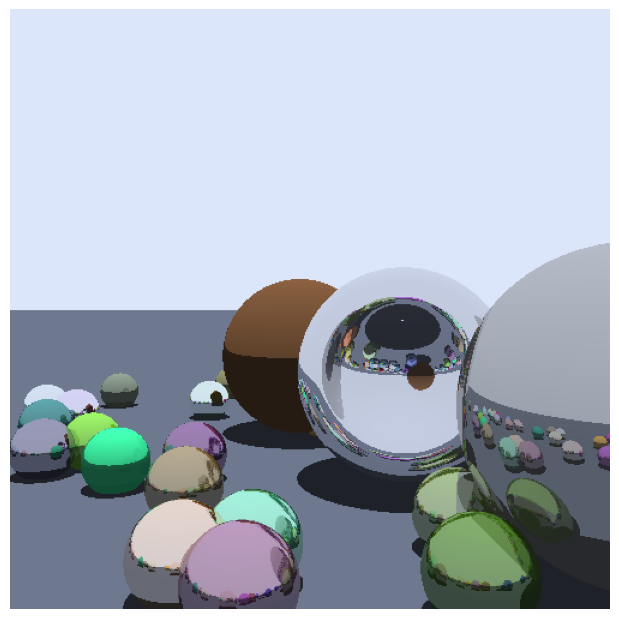

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class Sphere:
    def __init__(self, center, radius, color, specular=0, reflective=0, inverse_reflection=False):
        self.center = np.array(center)
        self.radius = radius
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective
        self.inverse_reflection = inverse_reflection  # New attribute to control inverse reflection

    def intersects(self, ray_origin, ray_direction):
        oc = ray_origin - self.center
        a = np.dot(ray_direction, ray_direction)
        b = 2 * np.dot(oc, ray_direction)
        c = np.dot(oc, oc) - self.radius ** 2
        discriminant = b ** 2 - 4 * a * c

        if discriminant < 0:
            return None, None

        t1 = (-b - np.sqrt(discriminant)) / (2 * a)
        t2 = (-b + np.sqrt(discriminant)) / (2 * a)
        return t1, t2

class Plane:
    def __init__(self, point, normal, color, specular=0, reflective=0):
        self.point = np.array(point)
        self.normal = np.array(normal) / np.linalg.norm(normal)
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective

    def intersects(self, ray_origin, ray_direction):
        denom = np.dot(ray_direction, self.normal)
        if abs(denom) < 1e-6:
            return None
        t = np.dot(self.point - ray_origin, self.normal) / denom
        return t if t > 0 else None

def closest_intersection(ray_origin, ray_direction, t_min, t_max, objects):
    closest_t = float('inf')
    closest_obj = None

    for obj in objects:
        if isinstance(obj, Sphere):
            t1, t2 = obj.intersects(ray_origin, ray_direction)
            if t1 is not None and t_min < t1 < t_max and t1 < closest_t:
                closest_t = t1
                closest_obj = obj
            if t2 is not None and t_min < t2 < t_max and t2 < closest_t:
                closest_t = t2
                closest_obj = obj
        elif isinstance(obj, Plane):
            t = obj.intersects(ray_origin, ray_direction)
            if t is not None and t_min < t < t_max and t < closest_t:
                closest_t = t
                closest_obj = obj

    return closest_obj, closest_t

def compute_lighting(point, normal, view, specular, lights, spheres):
    intensity = 0.0

    for light in lights:
        if light['type'] == 'ambient':
            intensity += light['intensity']
        else:
            if light['type'] == 'point':
                light_dir = light['position'] - point
                t_max = 1
            elif light['type'] == 'directional':
                light_dir = light['direction']
                t_max = float('inf')

            light_dir = light_dir / np.linalg.norm(light_dir)

            shadow_sphere, shadow_t = closest_intersection(point, light_dir, 0.001, t_max, spheres)
            if shadow_sphere is not None:
                continue

            n_dot_l = np.dot(normal, light_dir)
            if n_dot_l > 0:
                intensity += light['intensity'] * n_dot_l

            if specular != -1:
                reflection = 2 * normal * np.dot(normal, light_dir) - light_dir
                r_dot_v = np.dot(reflection, view)
                if r_dot_v > 0:
                    intensity += light['intensity'] * (r_dot_v ** specular)

    return intensity

def trace_ray(ray_origin, ray_direction, t_min, t_max, objects, lights, recursion_depth):
    closest_obj, closest_t = closest_intersection(ray_origin, ray_direction, t_min, t_max, objects)
    if closest_obj is None:
        return np.array([220, 230, 250])

    point = ray_origin + closest_t * ray_direction
    normal = (point - closest_obj.center) / closest_obj.radius if isinstance(closest_obj, Sphere) else closest_obj.normal
    view = -ray_direction

    lighting = compute_lighting(point, normal, view, closest_obj.specular, lights, objects)
    local_color = closest_obj.color * lighting

    reflectiveness = closest_obj.reflective
    if recursion_depth <= 0 or reflectiveness <= 0:
        return np.clip(local_color, 0, 255)

    # Check if this sphere should use inverse reflection
    reflection_direction = ray_direction - 2 * np.dot(ray_direction, normal) * normal
    if closest_obj.inverse_reflection:  # Apply the inverse reflection logic here
        # Reflect the direction as if it hit the opposite hemisphere
        reflection_direction = -reflection_direction  # Inverse the reflection direction to simulate the opposite hemisphere

    reflection_color = trace_ray(point, reflection_direction, 0.001, float('inf'), objects, lights, recursion_depth - 1)

    final_color = (1 - reflectiveness) * local_color + reflectiveness * reflection_color
    return np.clip(final_color, 0, 255)

def render_image(width, height, viewport_size, projection_plane_d, objects, lights, camera_position, camera_rotation):
    image = np.zeros((height, width, 3), dtype=np.uint8)
    rotation_matrix = np.array([[np.cos(np.radians(camera_rotation[1])), 0, np.sin(np.radians(camera_rotation[1]))],
                                [0, 1, 0],
                                [-np.sin(np.radians(camera_rotation[1])), 0, np.cos(np.radians(camera_rotation[1]))]])
    
    for x in range(width):
        for y in range(height):
            px = (x - width / 2) * viewport_size / width
            py = -(y - height / 2) * viewport_size / height
            ray_direction = np.array([px, py, projection_plane_d])
            ray_direction = rotation_matrix @ ray_direction
            ray_direction = ray_direction / np.linalg.norm(ray_direction)

            color = trace_ray(camera_position, ray_direction, 0.001, float('inf'), objects, lights, recursion_depth=3)
            image[y, x] = color

    return image

if __name__ == "__main__":
    width, height = 500, 500
    camera_position = np.array([24, 8, -16])
    camera_rotation = (11, -65, 0)
    
    objects = [
        Sphere((12, 5, 0), 5, (181, 181, 181), 500, 0.6),  # Normal sphere
        Sphere((0, 5, 0), 5, (200, 200, 255), 500, 0.9, inverse_reflection=True),  # Inverse reflection sphere
        Sphere((-12, 5, 0), 5, (129, 90, 60), 0, 0),
        Plane((0, 0, 0), (0, 1, 0), (100, 110, 130), 0, 0)
    ]
    
    # Random small spheres
    np.random.seed(42)  # For reproducibility
    small_spheres = []
    for _ in range(100):
        x, z = np.random.uniform(-30, 30, 2)
        color = np.random.randint(0, 256, 3)
        reflectiveness = np.random.uniform(0, 1)  # Random reflectiveness between 0 and 0.9
        small_spheres.append(Sphere(center=(x, 1.2, z), radius=1.5, color=color, reflective=reflectiveness))

    objects = objects + small_spheres
    
    lights = [
        {'type': 'ambient', 'intensity': 0.3},
        {'type': 'point', 'intensity': 0, 'position': np.array([0, 0, 0])},
        {'type': 'directional', 'intensity': 0.4, 'direction': np.array([0, 3, 0])}
    ]
    
    image = render_image(width, height, 1.0, 1.0, objects, lights, camera_position, camera_rotation)
    plt.figure(figsize=(6, 6), dpi=100)
    plt.imshow(image)
    plt.axis('off')
    plt.gca().set_position([0, 0, 1, 1])
    plt.show()


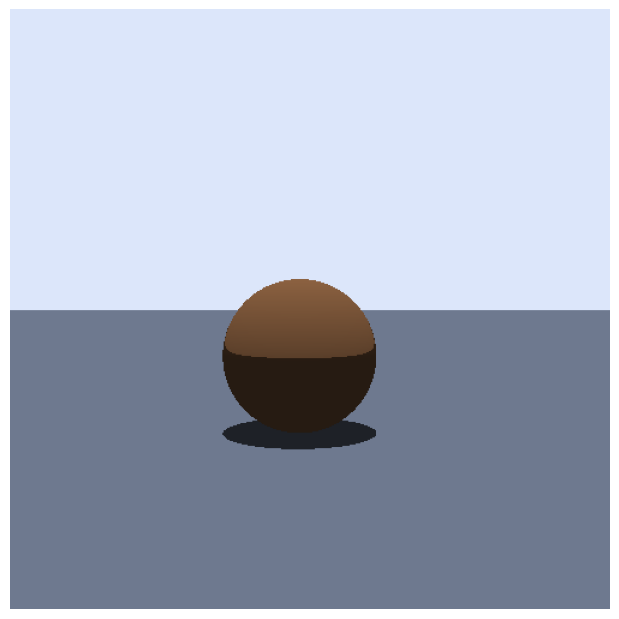

In [70]:
import numpy as np
import matplotlib.pyplot as plt

class Sphere:
    def __init__(self, center, radius, color, specular=0, reflective=0, inverse_reflection=False):
        self.center = np.array(center)
        self.radius = radius
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective
        self.inverse_reflection = inverse_reflection  # New attribute to control inverse reflection

    def intersects(self, ray_origin, ray_direction):
        oc = ray_origin - self.center
        a = np.dot(ray_direction, ray_direction)
        b = 2 * np.dot(oc, ray_direction)
        c = np.dot(oc, oc) - self.radius ** 2
        discriminant = b ** 2 - 4 * a * c

        if discriminant < 0:
            return None, None

        t1 = (-b - np.sqrt(discriminant)) / (2 * a)
        t2 = (-b + np.sqrt(discriminant)) / (2 * a)
        return t1, t2

class Plane:
    def __init__(self, point, normal, color, specular=0, reflective=0):
        self.point = np.array(point)
        self.normal = np.array(normal) / np.linalg.norm(normal)
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective

    def intersects(self, ray_origin, ray_direction):
        denom = np.dot(ray_direction, self.normal)
        if abs(denom) < 1e-6:
            return None
        t = np.dot(self.point - ray_origin, self.normal) / denom
        return t if t > 0 else None

def closest_intersection(ray_origin, ray_direction, t_min, t_max, objects):
    closest_t = float('inf')
    closest_obj = None

    for obj in objects:
        if isinstance(obj, Sphere):
            t1, t2 = obj.intersects(ray_origin, ray_direction)
            if t1 is not None and t_min < t1 < t_max and t1 < closest_t:
                closest_t = t1
                closest_obj = obj
            if t2 is not None and t_min < t2 < t_max and t2 < closest_t:
                closest_t = t2
                closest_obj = obj
        elif isinstance(obj, Plane):
            t = obj.intersects(ray_origin, ray_direction)
            if t is not None and t_min < t < t_max and t < closest_t:
                closest_t = t
                closest_obj = obj

    return closest_obj, closest_t

def compute_lighting(point, normal, view, specular, lights, spheres):
    intensity = 0.0

    for light in lights:
        if light['type'] == 'ambient':
            intensity += light['intensity']
        else:
            if light['type'] == 'point':
                light_dir = light['position'] - point
                t_max = 1
            elif light['type'] == 'directional':
                light_dir = light['direction']
                t_max = float('inf')

            light_dir = light_dir / np.linalg.norm(light_dir)

            shadow_sphere, shadow_t = closest_intersection(point, light_dir, 0.001, t_max, spheres)
            if shadow_sphere is not None:
                continue

            n_dot_l = np.dot(normal, light_dir)
            if n_dot_l > 0:
                intensity += light['intensity'] * n_dot_l

            if specular != -1:
                reflection = 2 * normal * np.dot(normal, light_dir) - light_dir
                r_dot_v = np.dot(reflection, view)
                if r_dot_v > 0:
                    intensity += light['intensity'] * (r_dot_v ** specular)

    return intensity

def trace_ray(ray_origin, ray_direction, t_min, t_max, objects, lights, recursion_depth):
    closest_obj, closest_t = closest_intersection(ray_origin, ray_direction, t_min, t_max, objects)
    if closest_obj is None:
        return np.array([220, 230, 250])

    point = ray_origin + closest_t * ray_direction
    normal = (point - closest_obj.center) / closest_obj.radius if isinstance(closest_obj, Sphere) else closest_obj.normal
    view = -ray_direction

    lighting = compute_lighting(point, normal, view, closest_obj.specular, lights, objects)
    local_color = closest_obj.color * lighting

    reflectiveness = closest_obj.reflective
    if recursion_depth <= 0 or reflectiveness <= 0:
        return np.clip(local_color, 0, 255)

    # Check if this sphere should use inverse reflection
    reflection_direction = ray_direction - 2 * np.dot(ray_direction, normal) * normal
    if closest_obj.inverse_reflection:  # Apply the inverse reflection logic here
        # Reflect the direction as if it hit the opposite hemisphere
        reflection_direction = -reflection_direction  # Inverse the reflection direction to simulate the opposite hemisphere

    reflection_color = trace_ray(point, reflection_direction, 0.001, float('inf'), objects, lights, recursion_depth - 1)

    final_color = (1 - reflectiveness) * local_color + reflectiveness * reflection_color
    return np.clip(final_color, 0, 255)

def render_image(width, height, viewport_size, projection_plane_d, objects, lights, camera_position, camera_rotation):
    image = np.zeros((height, width, 3), dtype=np.uint8)
    rotation_matrix = np.array([[np.cos(np.radians(camera_rotation[1])), 0, np.sin(np.radians(camera_rotation[1]))],
                                [0, 1, 0],
                                [-np.sin(np.radians(camera_rotation[1])), 0, np.cos(np.radians(camera_rotation[1]))]])
    
    for x in range(width):
        for y in range(height):
            px = (x - width / 2) * viewport_size / width
            py = -(y - height / 2) * viewport_size / height
            ray_direction = np.array([px, py, projection_plane_d])
            ray_direction = rotation_matrix @ ray_direction
            ray_direction = ray_direction / np.linalg.norm(ray_direction)

            color = trace_ray(camera_position, ray_direction, 0.001, float('inf'), objects, lights, recursion_depth=3)
            image[y, x] = color

    return image

if __name__ == "__main__":
    width, height = 500, 500
    camera_position = np.array([24, 8, -16])
    camera_rotation = (11, -65, 0)
    
    objects = [
        #Sphere((12, 5, 0), 5, (181, 181, 181), 500, 0.6),  # Normal sphere
        #Sphere((0, 5, 0), 5, (200, 200, 255), 500, 0.9, inverse_reflection=True),  # Inverse reflection sphere
        Sphere((-12, 5, 0), 5, (129, 90, 60), 0.01, 0),
        Plane((0, 0, 0), (0, 1, 0), (100, 110, 130), 0, 0)
    ]
    
    
    lights = [
        {'type': 'ambient', 'intensity': 0.3},
        {'type': 'point', 'intensity': 0, 'position': np.array([0, 0, 0])},
        {'type': 'directional', 'intensity': 0.4, 'direction': np.array([0, 3, 0])}
    ]
    
    image = render_image(width, height, 1.0, 1.0, objects, lights, camera_position, camera_rotation)
    plt.figure(figsize=(6, 6), dpi=100)
    plt.imshow(image)
    plt.axis('off')
    plt.gca().set_position([0, 0, 1, 1])
    plt.show()


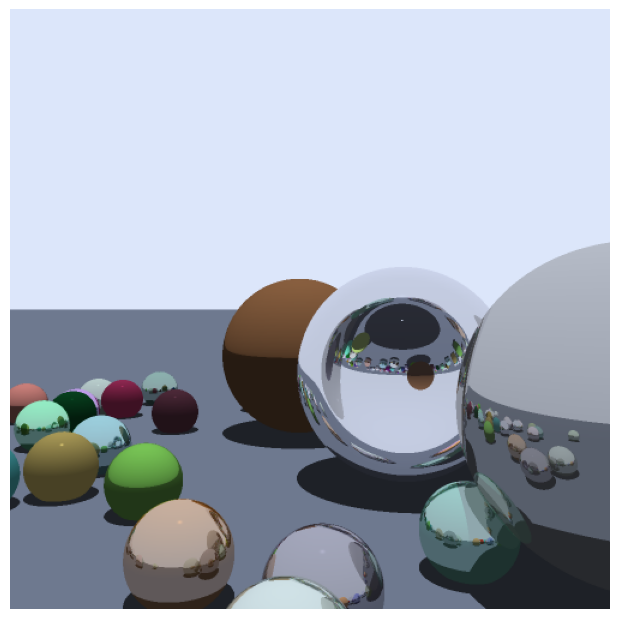

In [64]:
import numpy as np
import matplotlib.pyplot as plt

class Sphere:
    def __init__(self, center, radius, color, specular=0, reflective=0, inverse_reflection=False):
        self.center = np.array(center)
        self.radius = radius
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective
        self.inverse_reflection = inverse_reflection  # New attribute to control inverse reflection

    def intersects(self, ray_origin, ray_direction):
        oc = ray_origin - self.center
        a = np.dot(ray_direction, ray_direction)
        b = 2 * np.dot(oc, ray_direction)
        c = np.dot(oc, oc) - self.radius ** 2
        discriminant = b ** 2 - 4 * a * c

        if discriminant < 0:
            return None, None

        t1 = (-b - np.sqrt(discriminant)) / (2 * a)
        t2 = (-b + np.sqrt(discriminant)) / (2 * a)
        return t1, t2

class Plane:
    def __init__(self, point, normal, color, specular=0, reflective=0):
        self.point = np.array(point)
        self.normal = np.array(normal) / np.linalg.norm(normal)
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective

    def intersects(self, ray_origin, ray_direction):
        denom = np.dot(ray_direction, self.normal)
        if abs(denom) < 1e-6:
            return None
        t = np.dot(self.point - ray_origin, self.normal) / denom
        return t if t > 0 else None

def closest_intersection(ray_origin, ray_direction, t_min, t_max, objects):
    closest_t = float('inf')
    closest_obj = None

    for obj in objects:
        if isinstance(obj, Sphere):
            t1, t2 = obj.intersects(ray_origin, ray_direction)
            if t1 is not None and t_min < t1 < t_max and t1 < closest_t:
                closest_t = t1
                closest_obj = obj
            if t2 is not None and t_min < t2 < t_max and t2 < closest_t:
                closest_t = t2
                closest_obj = obj
        elif isinstance(obj, Plane):
            t = obj.intersects(ray_origin, ray_direction)
            if t is not None and t_min < t < t_max and t < closest_t:
                closest_t = t
                closest_obj = obj

    return closest_obj, closest_t

def compute_lighting(point, normal, view, specular, lights, spheres):
    intensity = 0.0

    for light in lights:
        if light['type'] == 'ambient':
            intensity += light['intensity']
        else:
            if light['type'] == 'point':
                light_dir = light['position'] - point
                t_max = 1
            elif light['type'] == 'directional':
                light_dir = light['direction']
                t_max = float('inf')

            light_dir = light_dir / np.linalg.norm(light_dir)

            shadow_sphere, shadow_t = closest_intersection(point, light_dir, 0.001, t_max, spheres)
            if shadow_sphere is not None:
                continue

            n_dot_l = np.dot(normal, light_dir)
            if n_dot_l > 0:
                intensity += light['intensity'] * n_dot_l

            if specular != -1:
                reflection = 2 * normal * np.dot(normal, light_dir) - light_dir
                r_dot_v = np.dot(reflection, view)
                if r_dot_v > 0:
                    intensity += light['intensity'] * (r_dot_v ** specular)

    return intensity

def trace_ray(ray_origin, ray_direction, t_min, t_max, objects, lights, recursion_depth):
    closest_obj, closest_t = closest_intersection(ray_origin, ray_direction, t_min, t_max, objects)
    if closest_obj is None:
        return np.array([220, 230, 250])

    point = ray_origin + closest_t * ray_direction
    normal = (point - closest_obj.center) / closest_obj.radius if isinstance(closest_obj, Sphere) else closest_obj.normal
    view = -ray_direction

    lighting = compute_lighting(point, normal, view, closest_obj.specular, lights, objects)
    local_color = closest_obj.color * lighting

    reflectiveness = closest_obj.reflective
    if recursion_depth <= 0 or reflectiveness <= 0:
        return np.clip(local_color, 0, 255)

    # Check if this sphere should use inverse reflection
    reflection_direction = ray_direction - 2 * np.dot(ray_direction, normal) * normal
    if closest_obj.inverse_reflection:  # Apply the inverse reflection logic here
        # Reflect the direction as if it hit the opposite hemisphere
        reflection_direction = -reflection_direction  # Inverse the reflection direction to simulate the opposite hemisphere

    reflection_color = trace_ray(point, reflection_direction, 0.001, float('inf'), objects, lights, recursion_depth - 1)

    final_color = (1 - reflectiveness) * local_color + reflectiveness * reflection_color
    return np.clip(final_color, 0, 255)

def render_image(width, height, viewport_size, projection_plane_d, objects, lights, camera_position, camera_rotation, ssaa_factor=2):
    ssaa_width = width * ssaa_factor
    ssaa_height = height * ssaa_factor
    image = np.zeros((ssaa_height, ssaa_width, 3), dtype=np.float32)
    
    rotation_matrix = np.array([[np.cos(np.radians(camera_rotation[1])), 0, np.sin(np.radians(camera_rotation[1]))],
                                [0, 1, 0],
                                [-np.sin(np.radians(camera_rotation[1])), 0, np.cos(np.radians(camera_rotation[1]))]])
    
    for x in range(ssaa_width):
        for y in range(ssaa_height):
            px = (x - ssaa_width / 2) * viewport_size / ssaa_width
            py = -(y - ssaa_height / 2) * viewport_size / ssaa_height
            ray_direction = np.array([px, py, projection_plane_d])
            ray_direction = rotation_matrix @ ray_direction
            ray_direction = ray_direction / np.linalg.norm(ray_direction)
            
            color = trace_ray(camera_position, ray_direction, 0.001, float('inf'), objects, lights, recursion_depth=3)
            image[y, x] = color
    
    # Downsample using averaging
    final_image = np.zeros((height, width, 3), dtype=np.uint8)
    for x in range(width):
        for y in range(height):
            final_image[y, x] = np.mean(image[y*ssaa_factor:(y+1)*ssaa_factor, x*ssaa_factor:(x+1)*ssaa_factor], axis=(0, 1))
    
    return final_image

if __name__ == "__main__":
    width, height = 500, 500
    camera_position = np.array([24, 8, -16])
    camera_rotation = (11, -65, 0)
    
    objects = [
        Sphere((12, 5, 0), 5, (181, 181, 181), 500, 0.6),  # Normal sphere
        Sphere((0, 5, 0), 5, (200, 200, 255), 500, 0.9, inverse_reflection=True),  # Inverse reflection sphere
        Sphere((-12, 5, 0), 5, (129, 90, 60), 0.1, 0),
        Plane((0, 0, 0), (0, 1, 0), (100, 110, 130), 0, 0)
    ]
    
    # Random small spheres
    np.random.seed(42)  # For reproducibility
    small_spheres = []
    for _ in range(100):
        x, z = np.random.uniform(-30, 30, 2)
        color = np.random.randint(0, 256, 3)
        specular = np.random.choice([0.1, 500])
        reflective = np.random.choice([0, 0.6, 0.9])
        small_spheres.append(Sphere(center=(x, 1.2, z), radius=1.5, color=color, specular=specular, reflective=reflective))

    
    objects = objects + small_spheres
    
    lights = [
        {'type': 'ambient', 'intensity': 0.3},
        {'type': 'point', 'intensity': 0, 'position': np.array([0, 0, 0])},
        {'type': 'directional', 'intensity': 0.4, 'direction': np.array([0, 3, 0])}
    ]
    
    image = render_image(width, height, 1.0, 1.0, objects, lights, camera_position, camera_rotation)
    plt.figure(figsize=(6, 6), dpi=100)
    plt.imshow(image)
    plt.axis('off')
    plt.gca().set_position([0, 0, 1, 1])
    plt.show()


Rendering Time: 1716.02 seconds


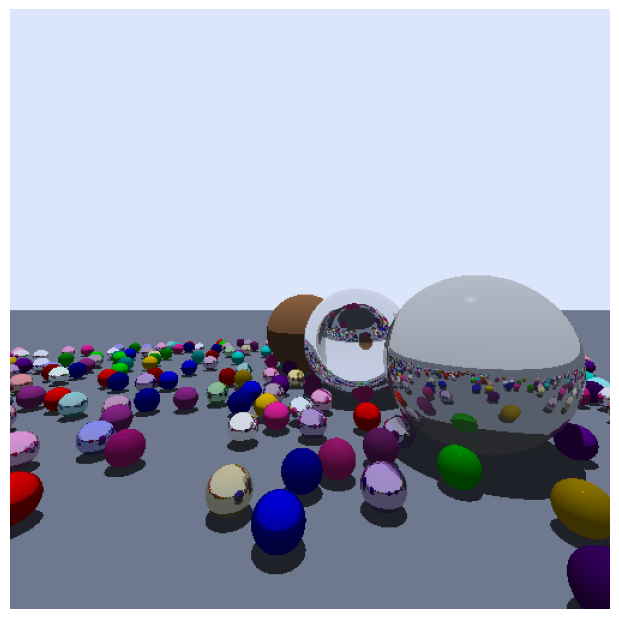

In [85]:
import random
import numpy as np
import matplotlib.pyplot as plt

class Sphere:
    def __init__(self, center, radius, color, specular=0, reflective=0, inverse_reflection=False):
        self.center = np.array(center)
        self.radius = radius
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective
        self.inverse_reflection = inverse_reflection  # New attribute to control inverse reflection

    def intersects(self, ray_origin, ray_direction):
        oc = ray_origin - self.center
        a = np.dot(ray_direction, ray_direction)
        b = 2 * np.dot(oc, ray_direction)
        c = np.dot(oc, oc) - self.radius ** 2
        discriminant = b ** 2 - 4 * a * c

        if discriminant < 0:
            return None, None

        t1 = (-b - np.sqrt(discriminant)) / (2 * a)
        t2 = (-b + np.sqrt(discriminant)) / (2 * a)
        return t1, t2

class Plane:
    def __init__(self, point, normal, color, specular=0, reflective=0):
        self.point = np.array(point)
        self.normal = np.array(normal) / np.linalg.norm(normal)
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective

    def intersects(self, ray_origin, ray_direction):
        denom = np.dot(ray_direction, self.normal)
        if abs(denom) < 1e-6:
            return None
        t = np.dot(self.point - ray_origin, self.normal) / denom
        return t if t > 0 else None

def closest_intersection(ray_origin, ray_direction, t_min, t_max, objects):
    closest_t = float('inf')
    closest_obj = None

    for obj in objects:
        if isinstance(obj, Sphere):
            t1, t2 = obj.intersects(ray_origin, ray_direction)
            if t1 is not None and t_min < t1 < t_max and t1 < closest_t:
                closest_t = t1
                closest_obj = obj
            if t2 is not None and t_min < t2 < t_max and t2 < closest_t:
                closest_t = t2
                closest_obj = obj
        elif isinstance(obj, Plane):
            t = obj.intersects(ray_origin, ray_direction)
            if t is not None and t_min < t < t_max and t < closest_t:
                closest_t = t
                closest_obj = obj

    return closest_obj, closest_t

def compute_lighting(point, normal, view, specular, lights, spheres):
    intensity = 0.0

    for light in lights:
        if light['type'] == 'ambient':
            intensity += light['intensity']
        else:
            if light['type'] == 'point':
                light_dir = light['position'] - point
                t_max = 1
            elif light['type'] == 'directional':
                light_dir = light['direction']
                t_max = float('inf')

            light_dir = light_dir / np.linalg.norm(light_dir)

            shadow_sphere, shadow_t = closest_intersection(point, light_dir, 0.001, t_max, spheres)
            if shadow_sphere is not None:
                continue

            n_dot_l = np.dot(normal, light_dir)
            if n_dot_l > 0:
                intensity += light['intensity'] * n_dot_l

            if specular != -1:
                reflection = 2 * normal * np.dot(normal, light_dir) - light_dir
                r_dot_v = np.dot(reflection, view)
                if r_dot_v > 0:
                    intensity += light['intensity'] * (r_dot_v ** specular)

    return intensity

def trace_ray(ray_origin, ray_direction, t_min, t_max, objects, lights, recursion_depth):
    closest_obj, closest_t = closest_intersection(ray_origin, ray_direction, t_min, t_max, objects)
    if closest_obj is None:
        return np.array([220, 230, 250])

    point = ray_origin + closest_t * ray_direction
    normal = (point - closest_obj.center) / closest_obj.radius if isinstance(closest_obj, Sphere) else closest_obj.normal
    view = -ray_direction

    lighting = compute_lighting(point, normal, view, closest_obj.specular, lights, objects)
    local_color = closest_obj.color * lighting

    reflectiveness = closest_obj.reflective
    if recursion_depth <= 0 or reflectiveness <= 0:
        return np.clip(local_color, 0, 255)

    # Check if this sphere should use inverse reflection
    reflection_direction = ray_direction - 2 * np.dot(ray_direction, normal) * normal
    if closest_obj.inverse_reflection:  # Apply the inverse reflection logic here
        # Reflect the direction as if it hit the opposite hemisphere
        reflection_direction = -reflection_direction  # Inverse the reflection direction to simulate the opposite hemisphere

    reflection_color = trace_ray(point, reflection_direction, 0.001, float('inf'), objects, lights, recursion_depth - 1)

    final_color = (1 - reflectiveness) * local_color + reflectiveness * reflection_color
    return np.clip(final_color, 0, 255)

def render_image(width, height, viewport_size, projection_plane_d, objects, lights, camera_position, camera_rotation):
    image = np.zeros((height, width, 3), dtype=np.uint8)
    rotation_matrix = np.array([[np.cos(np.radians(camera_rotation[1])), 0, np.sin(np.radians(camera_rotation[1]))],
                                [0, 1, 0],
                                [-np.sin(np.radians(camera_rotation[1])), 0, np.cos(np.radians(camera_rotation[1]))]])
    
    for x in range(width):
        for y in range(height):
            px = (x - width / 2) * viewport_size / width
            py = -(y - height / 2) * viewport_size / height
            ray_direction = np.array([px, py, projection_plane_d])
            ray_direction = rotation_matrix @ ray_direction
            ray_direction = ray_direction / np.linalg.norm(ray_direction)

            color = trace_ray(camera_position, ray_direction, 0.001, float('inf'), objects, lights, recursion_depth=3)
            image[y, x] = color

    return image

if __name__ == "__main__":
    width, height = 500, 500
    camera_position = np.array([24, 8, -16])
    camera_rotation = (11, -65, 0)
    
    objects = [
        Sphere((12, 5, 0), 5, (181, 181, 181), 500, 0.6),  # Normal sphere
        Sphere((0, 5, 0), 5, (200, 200, 255), 500, 0.9, inverse_reflection=True),  # Inverse reflection sphere
        Sphere((-12, 5, 0), 5, (129, 90, 60), 0, 0),
        Plane((0, 0, 0), (0, 1, 0), (100, 110, 130), 0, 0)
    ]
    
    beautiful_colors = [
    [200, 0, 0],       # red
    [0, 200, 0],       # green
    [0, 0, 200],       # blue
    [200, 165, 0],     # Vibrant orange
    [75, 0, 130],      # Indigo
    [130, 35, 130],   # Violet
    [210, 30, 150],   # Hot pink
    [0, 200, 200],     # Cyan
    [200, 20, 150],    # Deep pink
    ]
    
    # Minimum allowed distance between sphere centers (adjust as needed)
    MIN_DISTANCE = 1.8  

    # Maximum attempts to find a non-colliding position
    MAX_ATTEMPTS = 100  

    np.random.seed(42)  # For reproducibility
    small_spheres = []

    for _ in range(400):
        for attempt in range(MAX_ATTEMPTS):  # Try multiple times to find a valid position
            x, z = np.random.uniform(-40, 40, 2)

            # Check for collisions
            collision = False
            for sphere in small_spheres:
                sx, _, sz = sphere.center
                distance = np.sqrt((x - sx) ** 2 + (z - sz) ** 2)
                if distance < MIN_DISTANCE:
                    collision = True
                    break

            if not collision:
                # If no collision, create sphere and add to list
                color = random.choice(beautiful_colors)
                specular = np.random.choice([0.1, 500])
                reflective = np.random.choice([0, 0.6, 0.9], p=[0.6, 0.3, 0.1])  

                small_spheres.append(Sphere(center=(x, 1.0, z), radius=0.9, color=color, specular=specular, reflective=reflective))
                break  # Exit the attempt loop once a valid position is found
                
    objects = objects + small_spheres
    
    lights = [
        {'type': 'ambient', 'intensity': 0.3},
        {'type': 'point', 'intensity': 0, 'position': np.array([0, 0, 0])},
        {'type': 'directional', 'intensity': 0.4, 'direction': np.array([0, 3, 0])}
    ]
    
    # Start timing
    start_time = time.time()

    
    image = render_image(width, height, 2.0, 1.0, objects, lights, camera_position, camera_rotation)
    
    # End timing
    end_time = time.time()
    render_time = end_time - start_time

    print(f"Rendering Time: {render_time:.2f} seconds")
    plt.figure(figsize=(6, 6), dpi=100)
    plt.imshow(image)
    plt.axis('off')
    plt.gca().set_position([0, 0, 1, 1])
    plt.show()


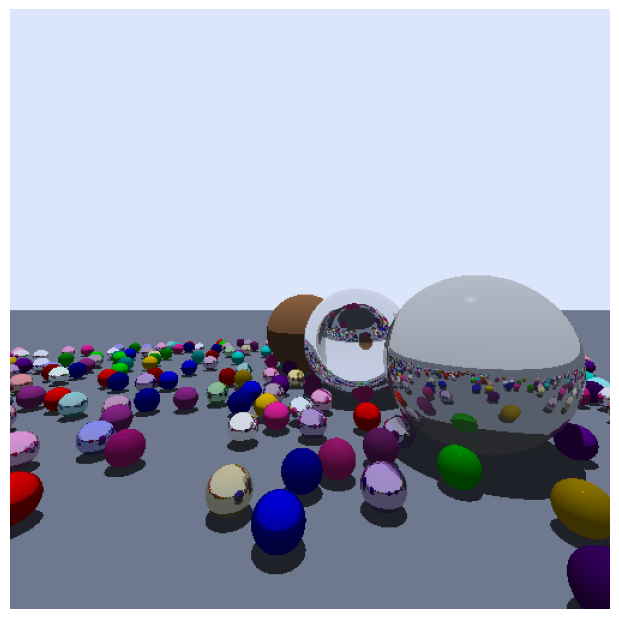

Rendering Time: 5875.36 seconds


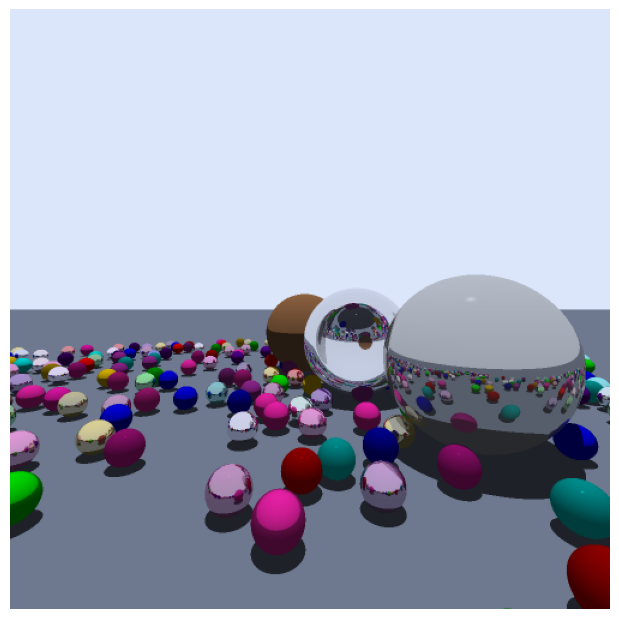

In [88]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt

class Sphere:
    def __init__(self, center, radius, color, specular=0, reflective=0, inverse_reflection=False):
        self.center = np.array(center)
        self.radius = radius
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective
        self.inverse_reflection = inverse_reflection  # New attribute to control inverse reflection

    def intersects(self, ray_origin, ray_direction):
        oc = ray_origin - self.center
        a = np.dot(ray_direction, ray_direction)
        b = 2 * np.dot(oc, ray_direction)
        c = np.dot(oc, oc) - self.radius ** 2
        discriminant = b ** 2 - 4 * a * c

        if discriminant < 0:
            return None, None

        t1 = (-b - np.sqrt(discriminant)) / (2 * a)
        t2 = (-b + np.sqrt(discriminant)) / (2 * a)
        return t1, t2

class Plane:
    def __init__(self, point, normal, color, specular=0, reflective=0):
        self.point = np.array(point)
        self.normal = np.array(normal) / np.linalg.norm(normal)
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective

    def intersects(self, ray_origin, ray_direction):
        denom = np.dot(ray_direction, self.normal)
        if abs(denom) < 1e-6:
            return None
        t = np.dot(self.point - ray_origin, self.normal) / denom
        return t if t > 0 else None

def closest_intersection(ray_origin, ray_direction, t_min, t_max, objects):
    closest_t = float('inf')
    closest_obj = None

    for obj in objects:
        if isinstance(obj, Sphere):
            t1, t2 = obj.intersects(ray_origin, ray_direction)
            if t1 is not None and t_min < t1 < t_max and t1 < closest_t:
                closest_t = t1
                closest_obj = obj
            if t2 is not None and t_min < t2 < t_max and t2 < closest_t:
                closest_t = t2
                closest_obj = obj
        elif isinstance(obj, Plane):
            t = obj.intersects(ray_origin, ray_direction)
            if t is not None and t_min < t < t_max and t < closest_t:
                closest_t = t
                closest_obj = obj

    return closest_obj, closest_t

def compute_lighting(point, normal, view, specular, lights, spheres):
    intensity = 0.0

    for light in lights:
        if light['type'] == 'ambient':
            intensity += light['intensity']
        else:
            if light['type'] == 'point':
                light_dir = light['position'] - point
                t_max = 1
            elif light['type'] == 'directional':
                light_dir = light['direction']
                t_max = float('inf')

            light_dir = light_dir / np.linalg.norm(light_dir)

            shadow_sphere, shadow_t = closest_intersection(point, light_dir, 0.001, t_max, spheres)
            if shadow_sphere is not None:
                continue

            n_dot_l = np.dot(normal, light_dir)
            if n_dot_l > 0:
                intensity += light['intensity'] * n_dot_l

            if specular != -1:
                reflection = 2 * normal * np.dot(normal, light_dir) - light_dir
                r_dot_v = np.dot(reflection, view)
                if r_dot_v > 0:
                    intensity += light['intensity'] * (r_dot_v ** specular)

    return intensity

def trace_ray(ray_origin, ray_direction, t_min, t_max, objects, lights, recursion_depth):
    closest_obj, closest_t = closest_intersection(ray_origin, ray_direction, t_min, t_max, objects)
    if closest_obj is None:
        return np.array([220, 230, 250])

    point = ray_origin + closest_t * ray_direction
    normal = (point - closest_obj.center) / closest_obj.radius if isinstance(closest_obj, Sphere) else closest_obj.normal
    view = -ray_direction

    lighting = compute_lighting(point, normal, view, closest_obj.specular, lights, objects)
    local_color = closest_obj.color * lighting

    reflectiveness = closest_obj.reflective
    if recursion_depth <= 0 or reflectiveness <= 0:
        return np.clip(local_color, 0, 255)

    # Check if this sphere should use inverse reflection
    reflection_direction = ray_direction - 2 * np.dot(ray_direction, normal) * normal
    if closest_obj.inverse_reflection:  # Apply the inverse reflection logic here
        # Reflect the direction as if it hit the opposite hemisphere
        reflection_direction = -reflection_direction  # Inverse the reflection direction to simulate the opposite hemisphere

    reflection_color = trace_ray(point, reflection_direction, 0.001, float('inf'), objects, lights, recursion_depth - 1)

    final_color = (1 - reflectiveness) * local_color + reflectiveness * reflection_color
    return np.clip(final_color, 0, 255)

def render_image(width, height, viewport_size, projection_plane_d, objects, lights, camera_position, camera_rotation, ssaa_factor=2):
    ssaa_width = width * ssaa_factor
    ssaa_height = height * ssaa_factor
    image = np.zeros((ssaa_height, ssaa_width, 3), dtype=np.float32)
    
    rotation_matrix = np.array([[np.cos(np.radians(camera_rotation[1])), 0, np.sin(np.radians(camera_rotation[1]))],
                                [0, 1, 0],
                                [-np.sin(np.radians(camera_rotation[1])), 0, np.cos(np.radians(camera_rotation[1]))]])
    
    for x in range(ssaa_width):
        for y in range(ssaa_height):
            px = (x - ssaa_width / 2) * viewport_size / ssaa_width
            py = -(y - ssaa_height / 2) * viewport_size / ssaa_height
            ray_direction = np.array([px, py, projection_plane_d])
            ray_direction = rotation_matrix @ ray_direction
            ray_direction = ray_direction / np.linalg.norm(ray_direction)
            
            color = trace_ray(camera_position, ray_direction, 0.001, float('inf'), objects, lights, recursion_depth=3)
            image[y, x] = color
    
    # Downsample using averaging
    final_image = np.zeros((height, width, 3), dtype=np.uint8)
    for x in range(width):
        for y in range(height):
            final_image[y, x] = np.mean(image[y*ssaa_factor:(y+1)*ssaa_factor, x*ssaa_factor:(x+1)*ssaa_factor], axis=(0, 1))
    
    return final_image

if __name__ == "__main__":
    width, height = 500, 500
    camera_position = np.array([24, 8, -16])
    camera_rotation = (11, -65, 0)
    
    objects = [
        Sphere((12, 5, 0), 5, (181, 181, 181), 500, 0.6),  # Normal sphere
        Sphere((0, 5, 0), 5, (200, 200, 255), 500, 0.9, inverse_reflection=True),  # Inverse reflection sphere
        Sphere((-12, 5, 0), 5, (129, 90, 60), 0.1, 0),
        Plane((0, 0, 0), (0, 1, 0), (100, 110, 130), 0, 0)
    ]
    
    # Random small spheres
    np.random.seed(42)  # For reproducibility
    small_spheres = []
    for _ in range(100):
        x, z = np.random.uniform(-30, 30, 2)
        color = np.random.randint(0, 256, 3)
        specular = np.random.choice([0.1, 500])
        reflective = np.random.choice([0, 0.6, 0.9])
        small_spheres.append(Sphere(center=(x, 1.2, z), radius=1.0, color=color, specular=specular, reflective=reflective))

    
    objects = objects + small_spheres
    
    lights = [
        {'type': 'ambient', 'intensity': 0.3},
        {'type': 'point', 'intensity': 0, 'position': np.array([0, 0, 0])},
        {'type': 'directional', 'intensity': 0.4, 'direction': np.array([0, 3, 0])}
    ]
    
    
    
    plt.figure(figsize=(6, 6), dpi=100)
    plt.imshow(image)
    plt.axis('off')
    plt.gca().set_position([0, 0, 1, 1])
    plt.show()
    
if __name__ == "__main__":
    width, height = 500, 500
    camera_position = np.array([24, 8, -16])
    camera_rotation = (11, -65, 0)
    
    objects = [
        Sphere((12, 5, 0), 5, (181, 181, 181), 500, 0.6),  # Normal sphere
        Sphere((0, 5, 0), 5, (200, 200, 255), 500, 0.9, inverse_reflection=True),  # Inverse reflection sphere
        Sphere((-12, 5, 0), 5, (129, 90, 60), 0, 0),
        Plane((0, 0, 0), (0, 1, 0), (100, 110, 130), 0, 0)
    ]
    
    beautiful_colors = [
    [200, 0, 0],       # red
    [0, 200, 0],       # green
    [0, 0, 200],       # blue
    [200, 165, 0],     # Vibrant orange
    [75, 0, 130],      # Indigo
    [130, 35, 130],   # Violet
    [210, 30, 150],   # Hot pink
    [0, 200, 200],     # Cyan
    [200, 20, 150],    # Deep pink
    ]
    
    # Minimum allowed distance between sphere centers (adjust as needed)
    MIN_DISTANCE = 1.8  

    # Maximum attempts to find a non-colliding position
    MAX_ATTEMPTS = 100  

    np.random.seed(42)  # For reproducibility
    small_spheres = []

    for _ in range(400):
        for attempt in range(MAX_ATTEMPTS):  # Try multiple times to find a valid position
            x, z = np.random.uniform(-40, 40, 2)

            # Check for collisions
            collision = False
            for sphere in small_spheres:
                sx, _, sz = sphere.center
                distance = np.sqrt((x - sx) ** 2 + (z - sz) ** 2)
                if distance < MIN_DISTANCE:
                    collision = True
                    break

            if not collision:
                # If no collision, create sphere and add to list
                color = random.choice(beautiful_colors)
                specular = np.random.choice([0.1, 500])
                reflective = np.random.choice([0, 0.6, 0.9], p=[0.6, 0.3, 0.1])  

                small_spheres.append(Sphere(center=(x, 1.0, z), radius=0.9, color=color, specular=specular, reflective=reflective))
                break  # Exit the attempt loop once a valid position is found
                
    objects = objects + small_spheres
    
    lights = [
        {'type': 'ambient', 'intensity': 0.3},
        {'type': 'point', 'intensity': 0, 'position': np.array([0, 0, 0])},
        {'type': 'directional', 'intensity': 0.4, 'direction': np.array([0, 3, 0])}
    ]
    
    # Start timing
    start_time = time.time()

    
    image = render_image(width, height, 2.0, 1.0, objects, lights, camera_position, camera_rotation)
    
    # End timing
    end_time = time.time()
    render_time = end_time - start_time

    print(f"Rendering Time: {render_time:.2f} seconds")
    plt.figure(figsize=(6, 6), dpi=100)
    plt.imshow(image)
    plt.axis('off')
    plt.gca().set_position([0, 0, 1, 1])
    plt.show()
